<a href="https://colab.research.google.com/github/kejti97/test/blob/master/MGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

od 4 pazdziernika 2018 do 23 stycznia 2020 jest 341 obserwacje.
24 stycznia 2020 początek kryzysu do 14 maja 2021 - piątku. Jest to 341 obserwacji


In [ ]:
%load_ext google.colab.data_table
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, DayLocator
from IPython.display import display
from tabulate import tabulate
from sklearn import preprocessing 
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from functools import reduce
from scipy import stats
from statsmodels.tsa.api import VAR
from scipy.stats.stats import pearsonr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

In [ ]:
# Reading data (only weekdays)
aex_nl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/aex_nl.csv", header=0 ,sep=";") # każdy po 879 wierszy
ath_el = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/ath_gr.csv", header=0 ,sep=";")  
bux_hu = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/bux_hu.csv", header=0 ,sep=";") 
cac_fr = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/cac_fr.csv", header=0 ,sep=";") 
dax_de = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/dax_de.csv", header=0 ,sep=";") 
ftse_gb = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/ftse_gb.csv", header=0, sep=";")
ibex_es = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/ibex_es.csv", header=0 ,sep=";") 
rts_ru = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/rts_ru.csv", header=0 ,sep=";") 
wig20_pl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/wig20_pl.csv", header=0 ,sep=";") 
xu100_tu = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mgr/tylko robocze/xu100_tu.csv", header=0 ,sep=";") 

In [ ]:
# Lists with all indexes with all dates
indexes_original = [aex_nl, ath_el, bux_hu, cac_fr, dax_de, ftse_gb, ibex_es, rts_ru, wig20_pl, xu100_tu]

# Dictionary with indexes names
indexes_names = {1:'aex_nl', 2:'ath_el', 3:'bux_hu', 4:'cac_fr', 5:'dax_de', 6:'ftse_gb', 7:'ibex_es', 8:'rts_ru', 9:'wig20_pl', 10:'xu100_tu'}
indexes_names = [aex_nl,'ath_el', 'bux_hu', 'cac_fr','dax_de', 'ftse_gb', 'ibex_es', 'rts_ru', 'wig20_pl', 'xu100_tu']

In [ ]:
# Making a copy for every of dataframe 
indexes_copy = indexes_original[:]

In [ ]:
# Creating a list with indexes as a time and taking dates for calm time and crisis - from 2018-10-04 to 2021-05-14
indexes = []
for i in indexes_copy:
  i["Data"] = pd.to_datetime(i["Data"])
  i["Zamkniecie"] = pd.to_numeric( i["Zamkniecie"])
  i.index = i["Data"]
  del i["Data"]
  i = i.loc["2018-10-04":"2021-05-14"]
  indexes.append(i)

# Checking how many NA values there are
for i in indexes:
  print(i.isna().sum())

Zamkniecie    16
dtype: int64
Zamkniecie    39
dtype: int64
Zamkniecie    38
dtype: int64
Zamkniecie    16
dtype: int64
Zamkniecie    25
dtype: int64
Zamkniecie    23
dtype: int64
Zamkniecie    16
dtype: int64
Zamkniecie    28
dtype: int64
Zamkniecie    34
dtype: int64
Zamkniecie    24
dtype: int64


In [ ]:
# Replace missing data - linear interpolation
indexes_interpolation = [i.interpolate(method='linear', axis=0, limit_direction="backward") for i in indexes]

# Checking how many NA there are still
for i in indexes_interpolation:
  print(i.isna().sum())

Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64
Zamkniecie    0
dtype: int64


In [ ]:
# # ACF and PACF tests for every indexes
# #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# #for i in range(len(indexes_interpolation)):
# # plot_acf(indexes_interpolation[i]['Zamkniecie'], lags=20)
# plot_pacf(indexes_interpolation[i]['Zamkniecie'], lags=20)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# plot_acf(indexes_interpolation[0]['Zamkniecie'], lags=20)
# plot_pacf(indexes_interpolation[0]['Zamkniecie'], lags=20)

In [ ]:
# Counting the difference of logarithm prices
for i in indexes_interpolation:
  i['log_stopy_zwrotu'] = 100 * np.log(i['Zamkniecie']).diff()

# for i in indexes_interpolation:
#  print(i.shape)

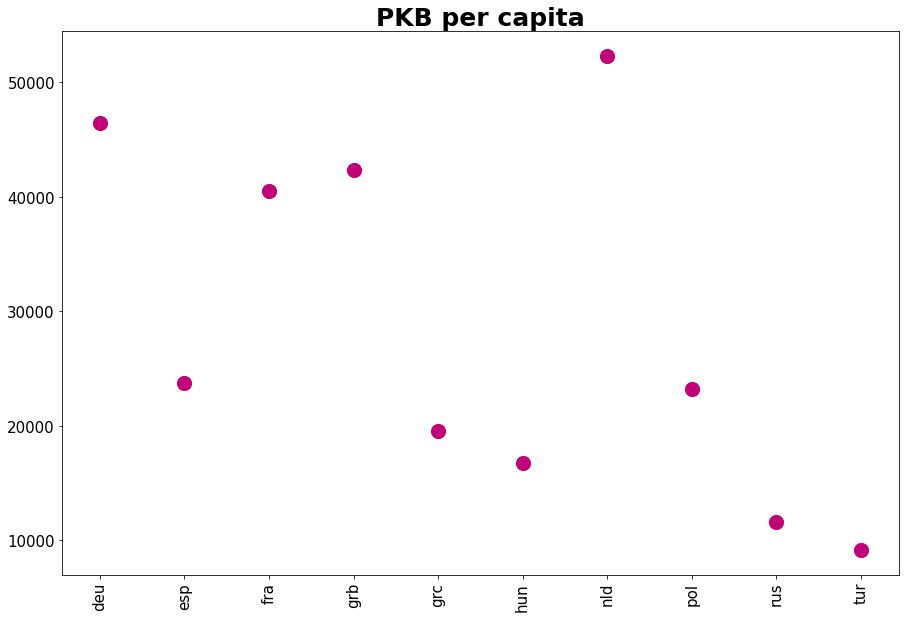

In [ ]:
# GDP per capita for each country for 2019
gdp_per_capita = {"nld": 52295, 
                  "grc": 19581, 
                  "hun": 16729.8,
                  "fra": 40496, 
                  "deu": 46467.5,
                  "grb": 42330.12,
                  "esp": 23717.8, 
                  "rus": 11585,
                  "pol": 23214,
                  "tur": 9126.56
                  }

annotations = gdp_per_capita.keys()
annotations = list(annotations)
gdp_per_capita = sorted(gdp_per_capita.items())


fig = plt.subplots(figsize = (15,10), linewidth=2)
x, y = zip(*gdp_per_capita)
plt.scatter(x, y, s=200, color="#C20078")
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("PKB per capita", fontsize= 25, fontweight="bold")
plt.show()


# Percentage change GDP per capita for 2019 

**Okres pokoju i kryzysu**

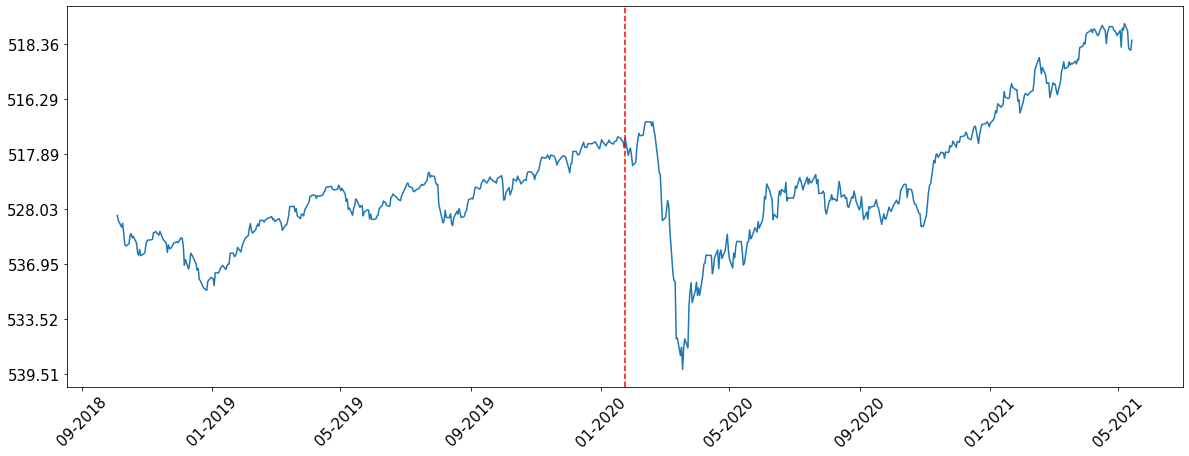

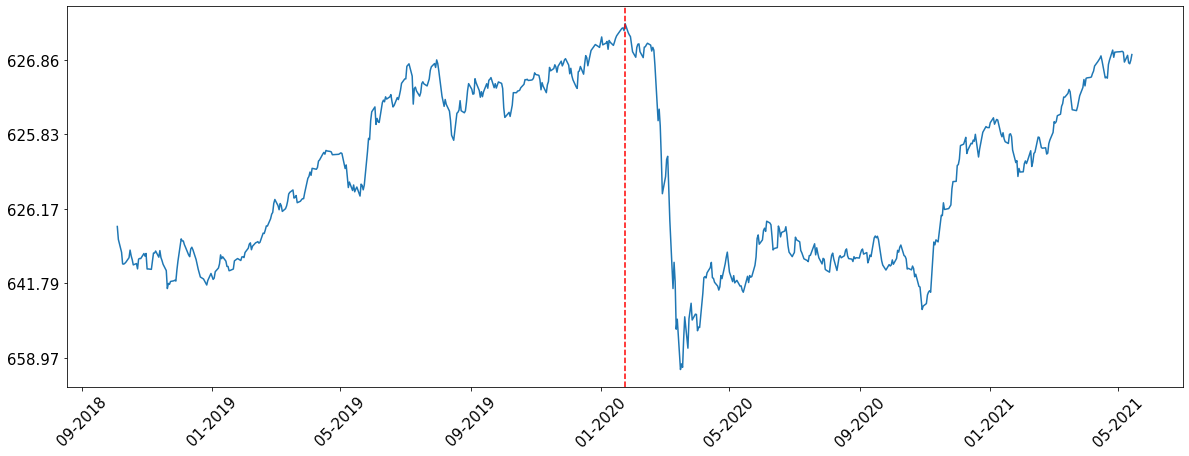

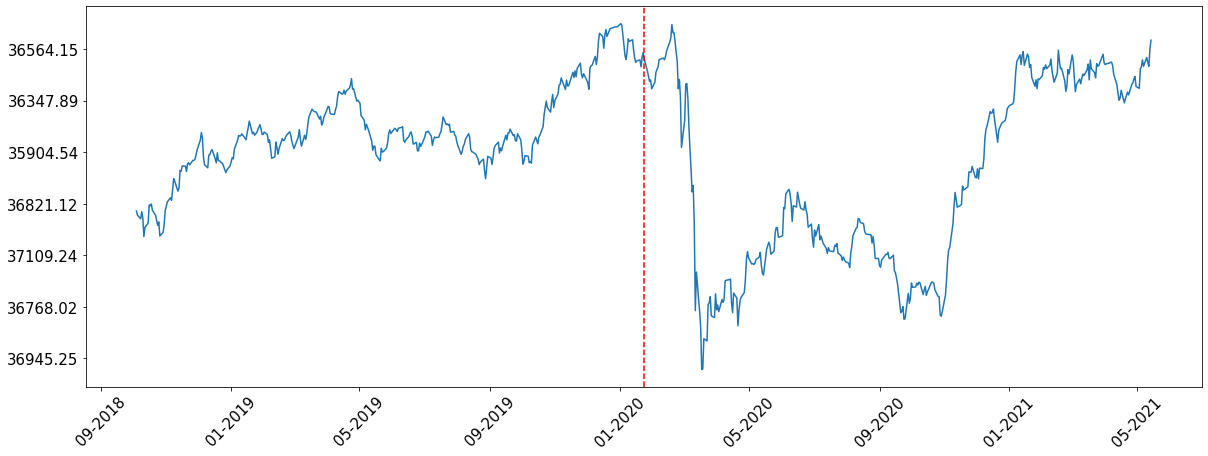

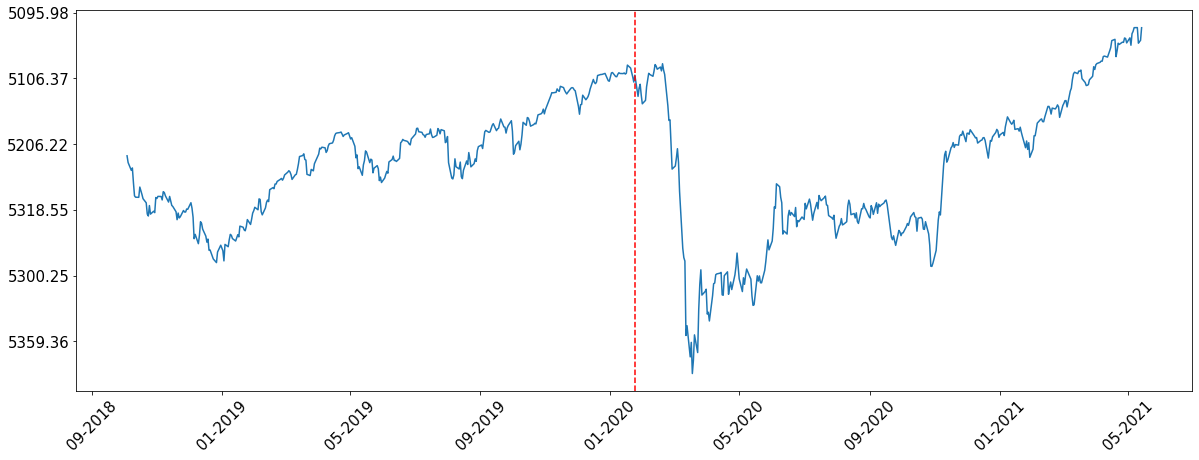

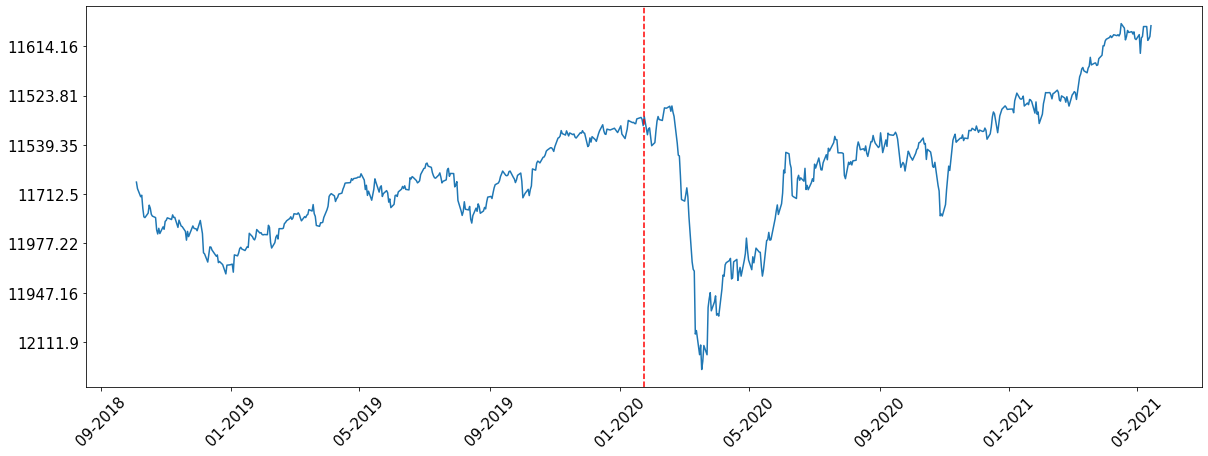

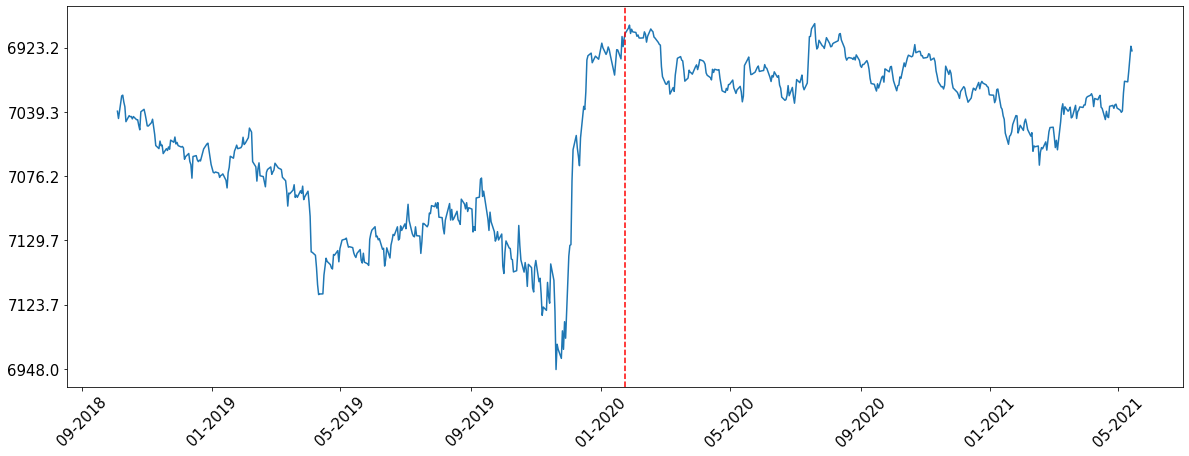

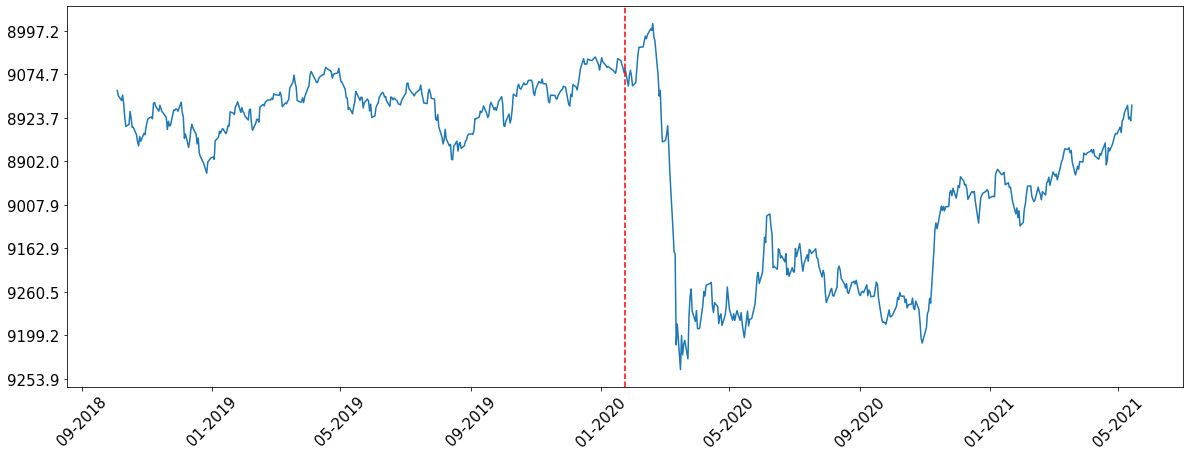

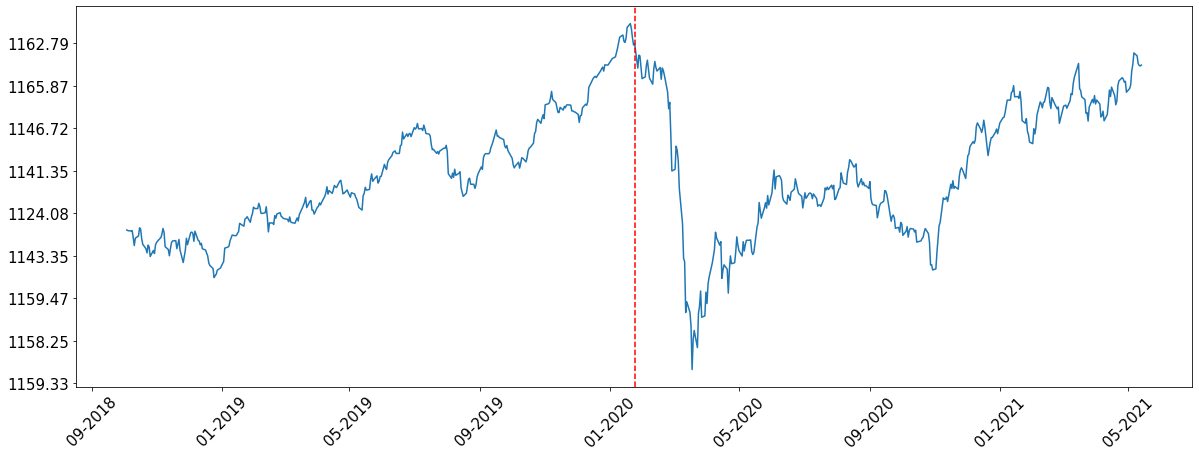

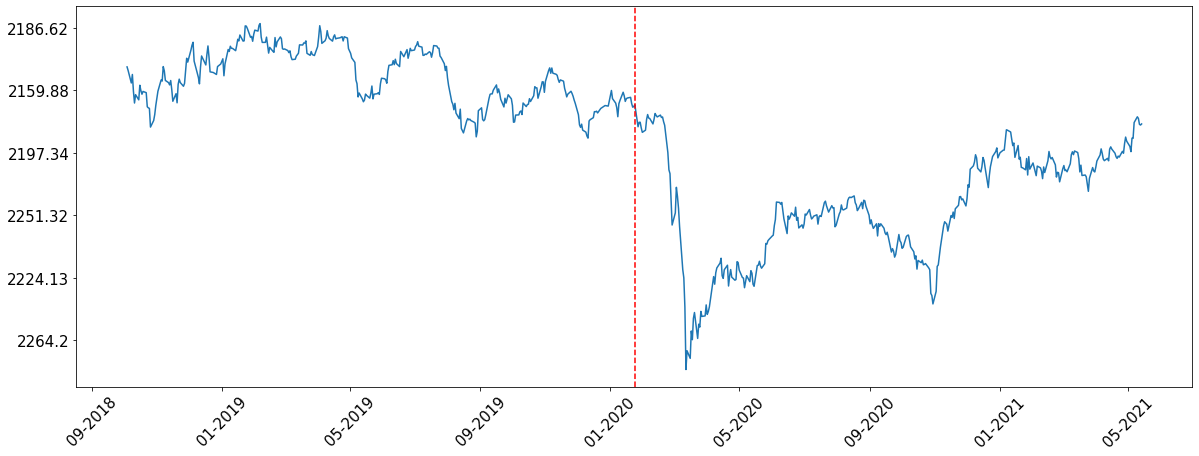

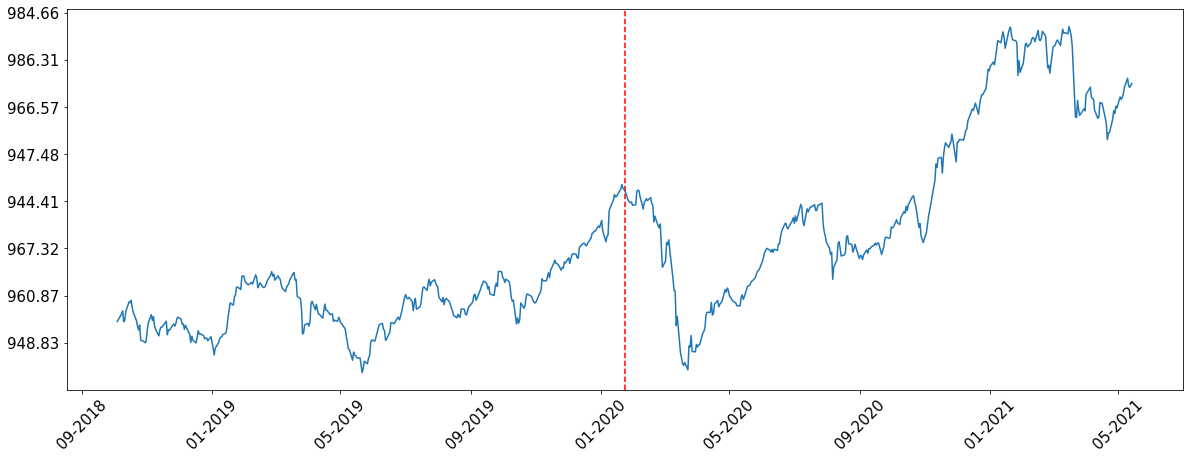

In [ ]:
# Plots for every indexes
for i in indexes_interpolation:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["Zamkniecie"], linestyle='-')
  ax.axvline(pd.to_datetime('2020-01-24'), color="red", linestyle="dashed")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["Zamkniecie"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

In [ ]:
# Checking if 'Zamkniecie' is stationary
for i in range(len(indexes_interpolation)):  
  result = adfuller(indexes_interpolation[i]['Zamkniecie'])
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  print("-----\n")

ADF Statistic: -1.172483
p-value: 0.685319
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -1.892009
p-value: 0.335830
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -2.348015
p-value: 0.156949
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -1.729679
p-value: 0.415889
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -1.432058
p-value: 0.566814
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -1.660535
p-value: 0.451552
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -2.027886
p-value: 0.274481
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -2.102496
p-value: 0.243512
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -1.923765
p-value: 0.320965
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
-----

ADF Statistic: -0.736046
p-value: 0.837191
Critical Values:
	1%:

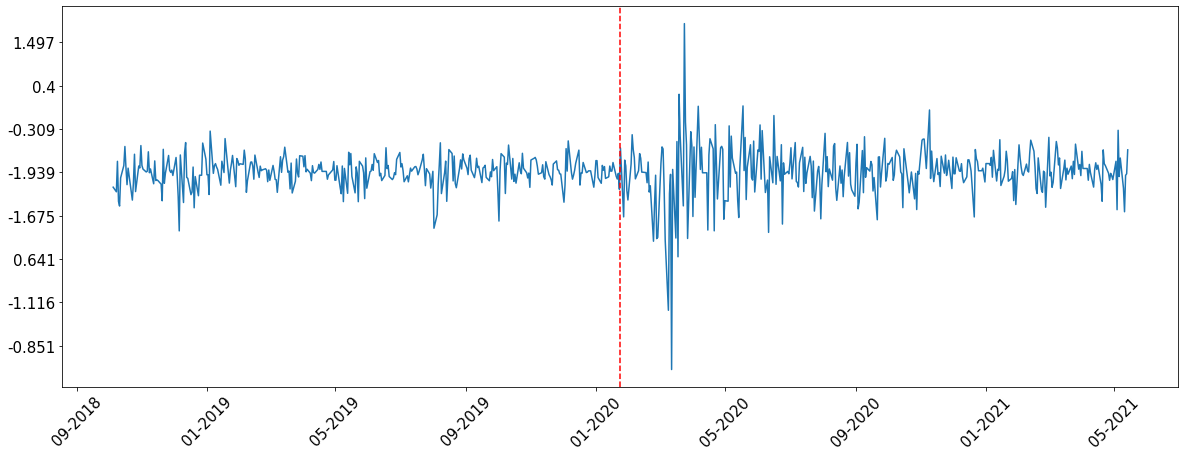

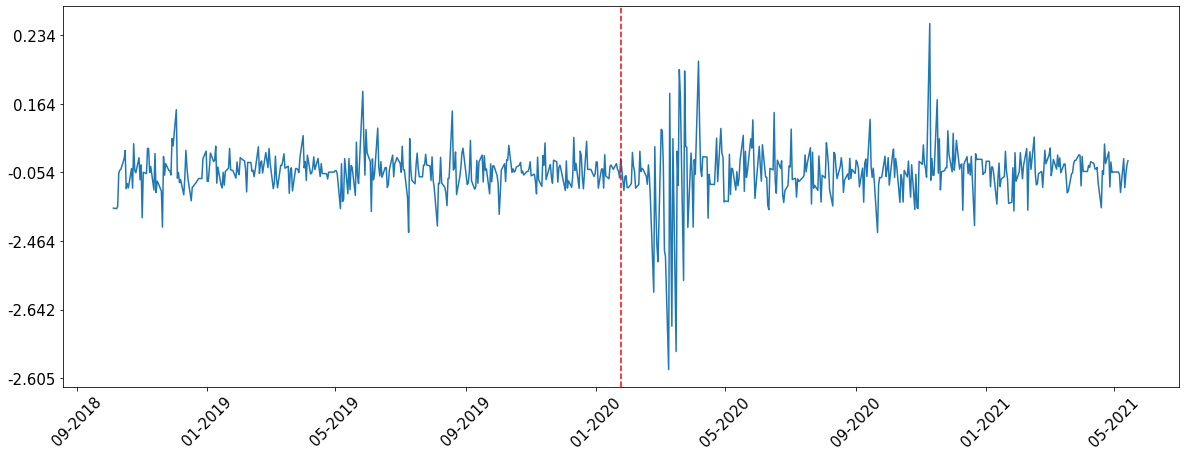

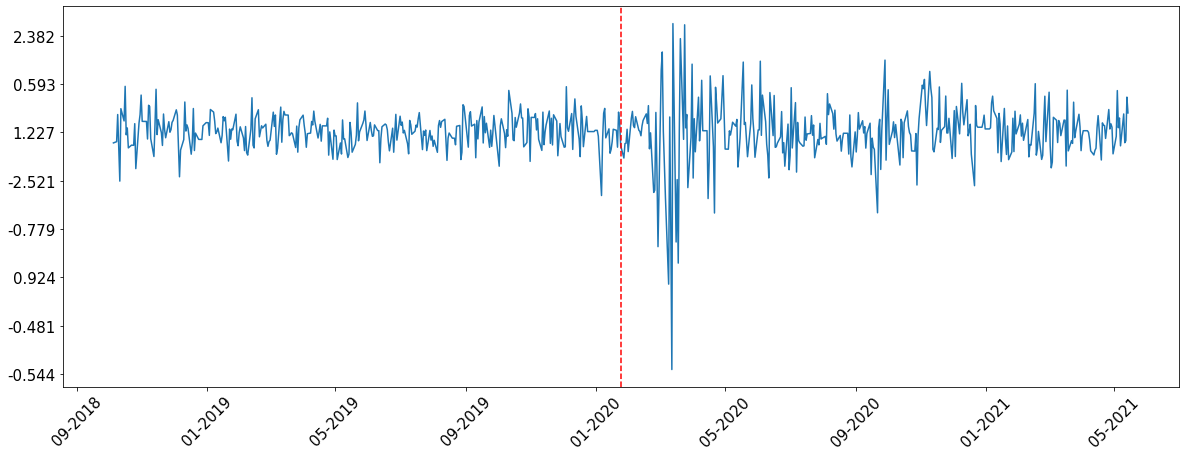

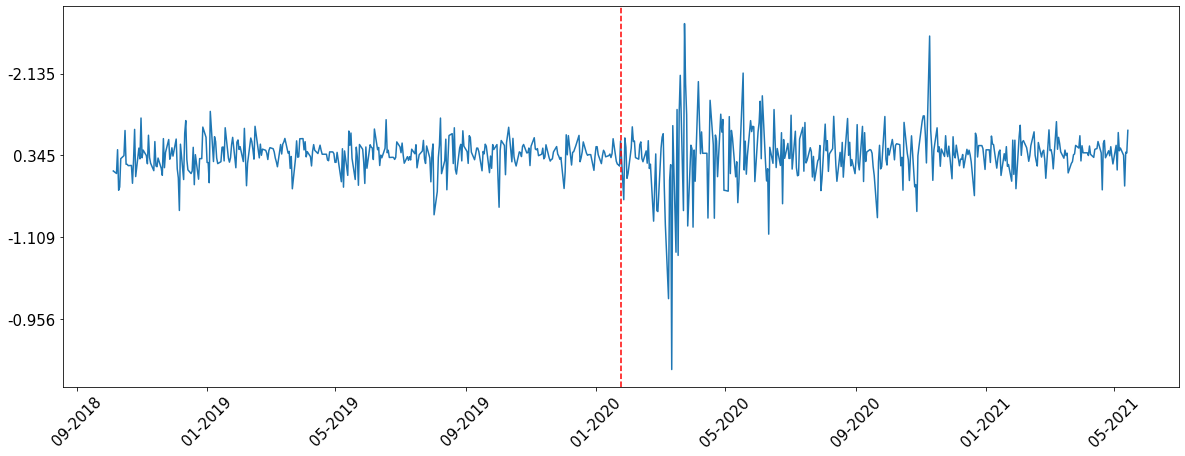

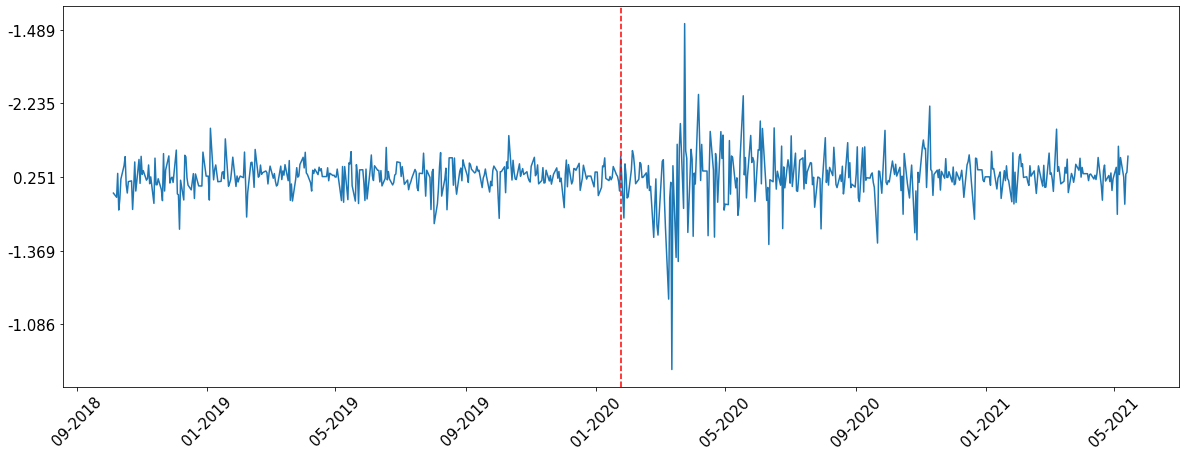

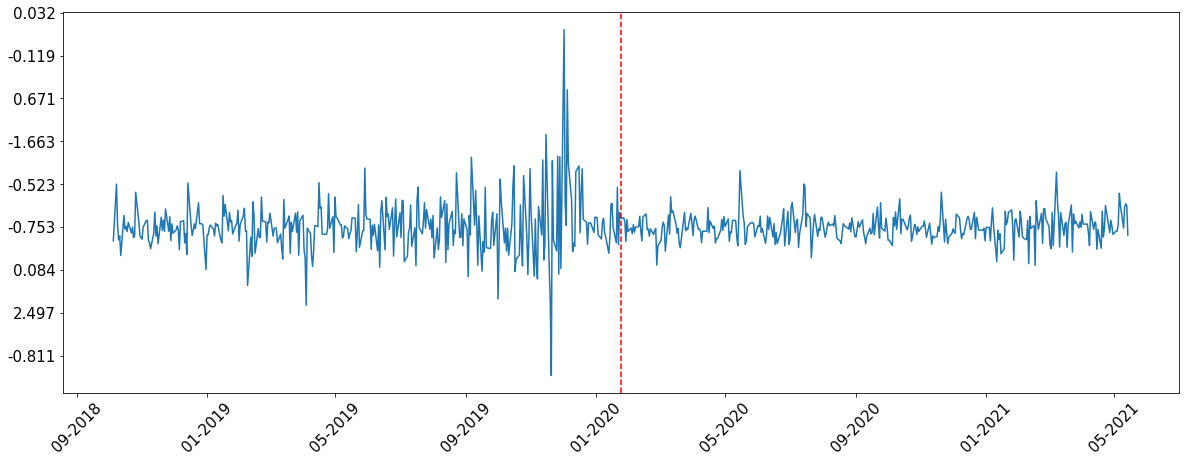

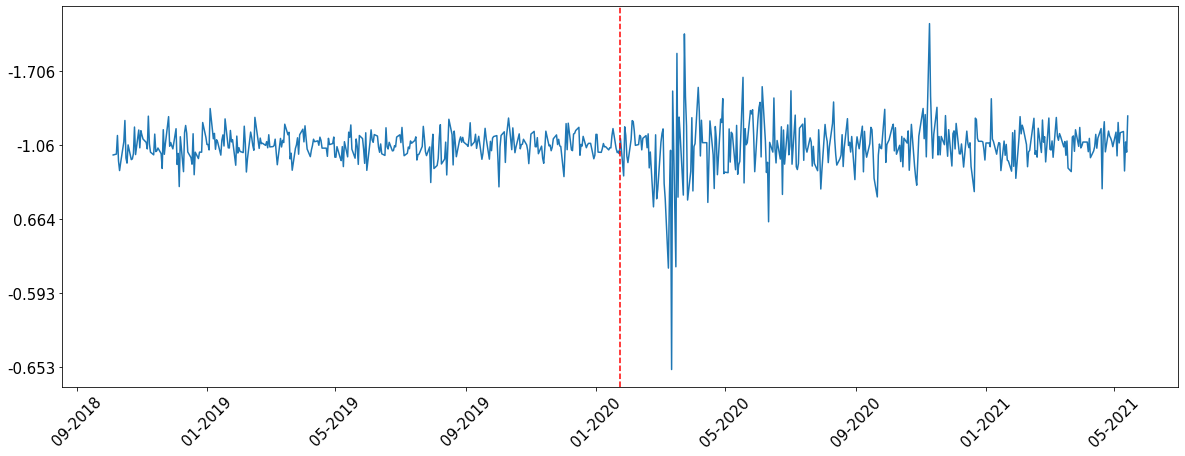

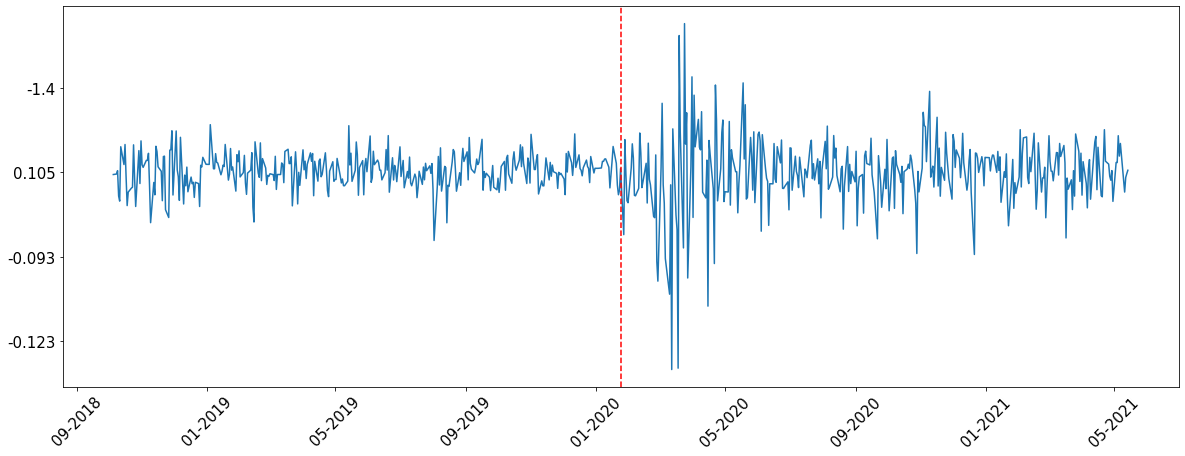

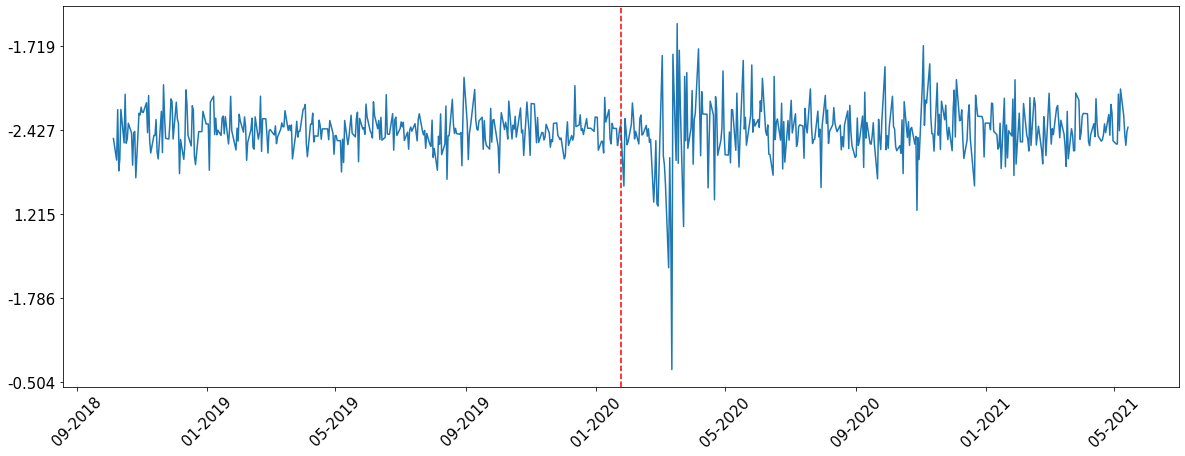

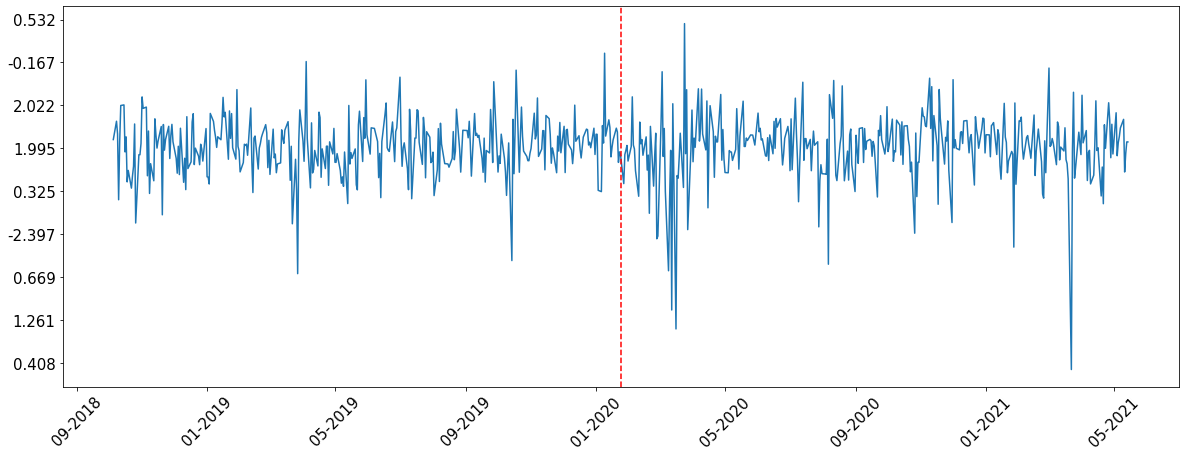

In [ ]:
# Plots for every logarithm's rate retrun indexes
for i in indexes_interpolation:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["log_stopy_zwrotu"], linestyle="-")
  ax.axvline(pd.to_datetime("2020-01-24"), color="red", linestyle="dashed")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["log_stopy_zwrotu"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

In [ ]:
# Standard deviation for every return rate
std_return_rates = [i["log_stopy_zwrotu"].std() for i in indexes_interpolation]
print(std_return_rates)

# Coefficient of variation for every return rate 
coeff_of_variation = [i["log_stopy_zwrotu"].std()/i["log_stopy_zwrotu"].mean() for i in indexes_interpolation]
print(coeff_of_variation)

# for i in indexes_interpolation:
#   a = i['log_stopy_zwrotu'].describe()
#   print(type(a))

[1.27487219752192, 1.828817837146222, 1.32431820559159, 1.4273248125177518, 1.4538632391383206, 1.2946389982770656, 1.4809349070190674, 1.7151805329204541, 1.4999850759036542, 1.4564578367851235]
[33.826859885687824, 42.43281115990277, 44.80681715912407, 58.7077686727541, 42.97226159886247, 135.75627274023904, -551.1189786103765, 40.48807043542565, -121.95023387416845, 23.167286846685773]


**Okres pokoju - od 4 pazdziernika 2018 do 23 stycznia 2020 jest 341 obserwacji**

In [ ]:
# The calm time
calm = [i.loc[:"2020-01-23"] for i in indexes_interpolation]
print(len(calm[0]))

341


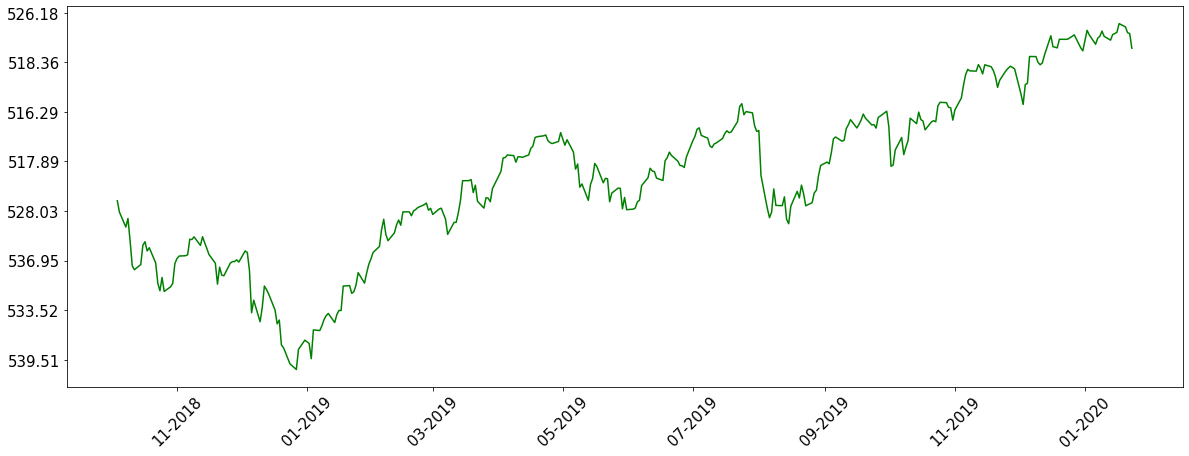

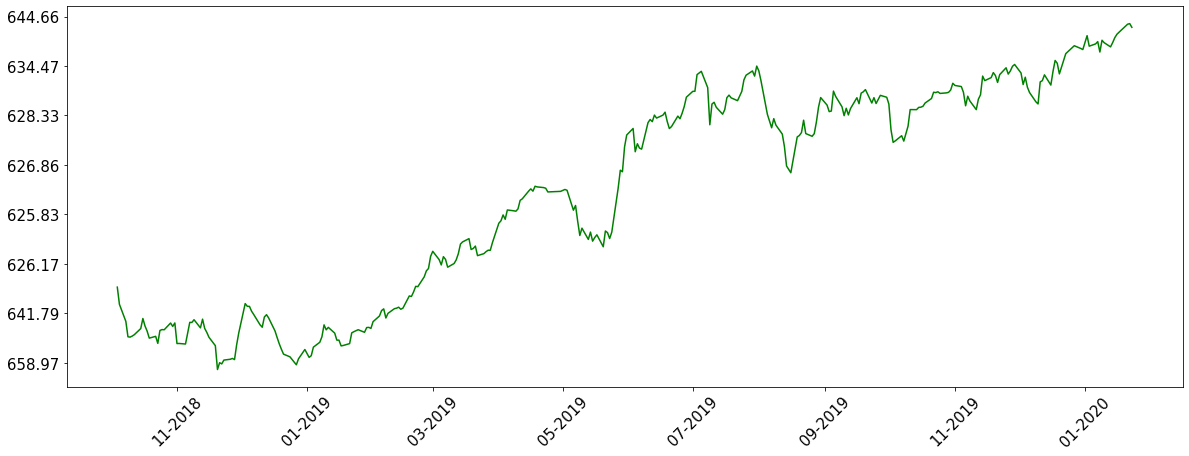

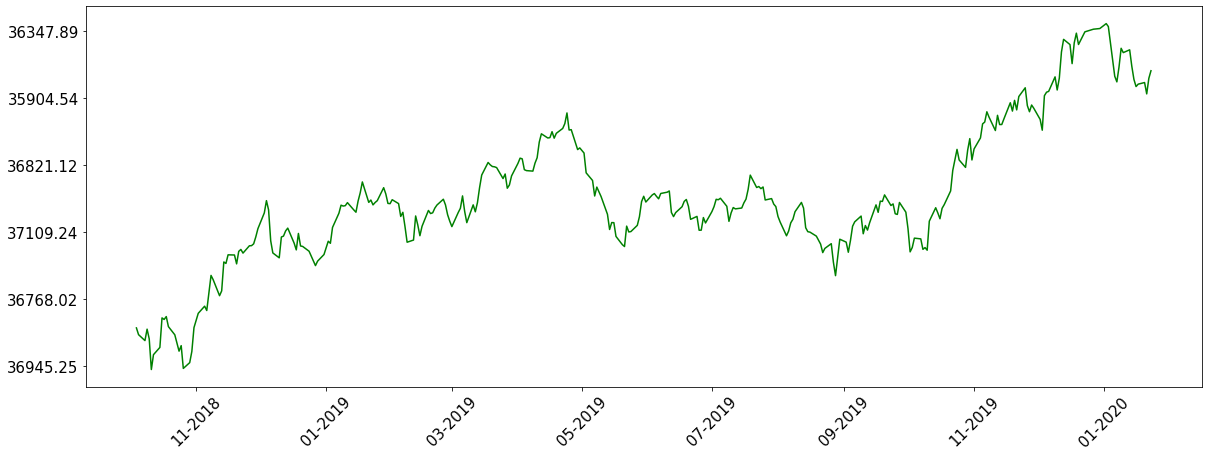

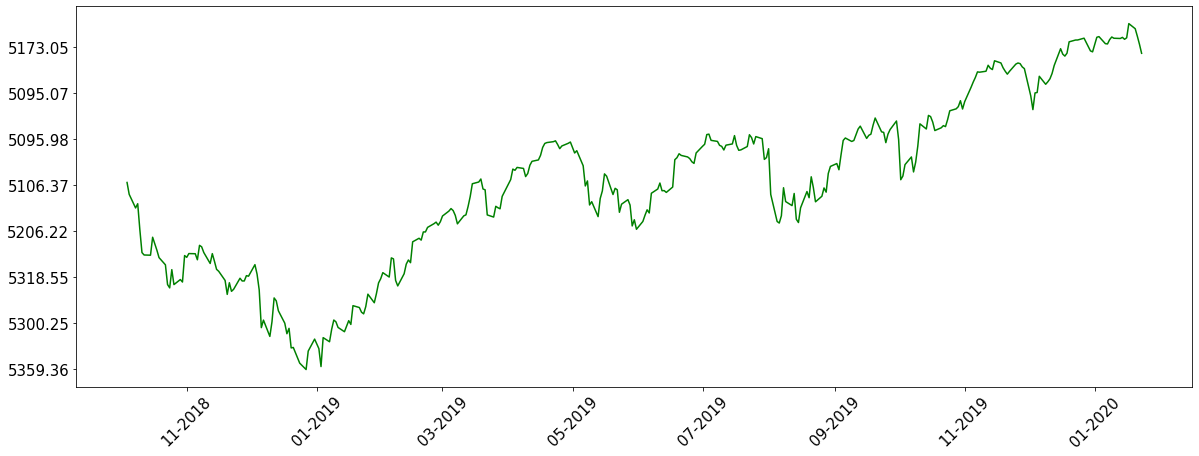

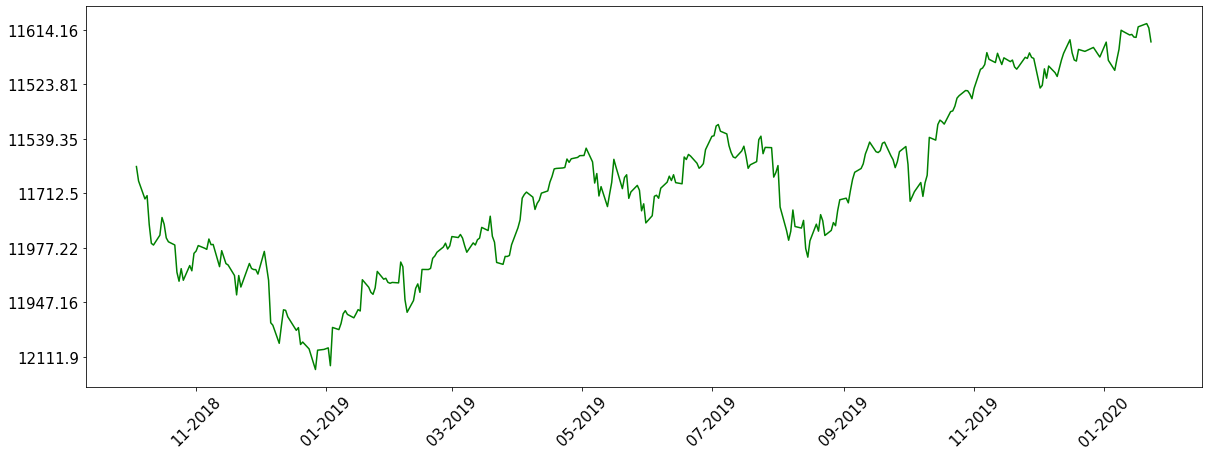

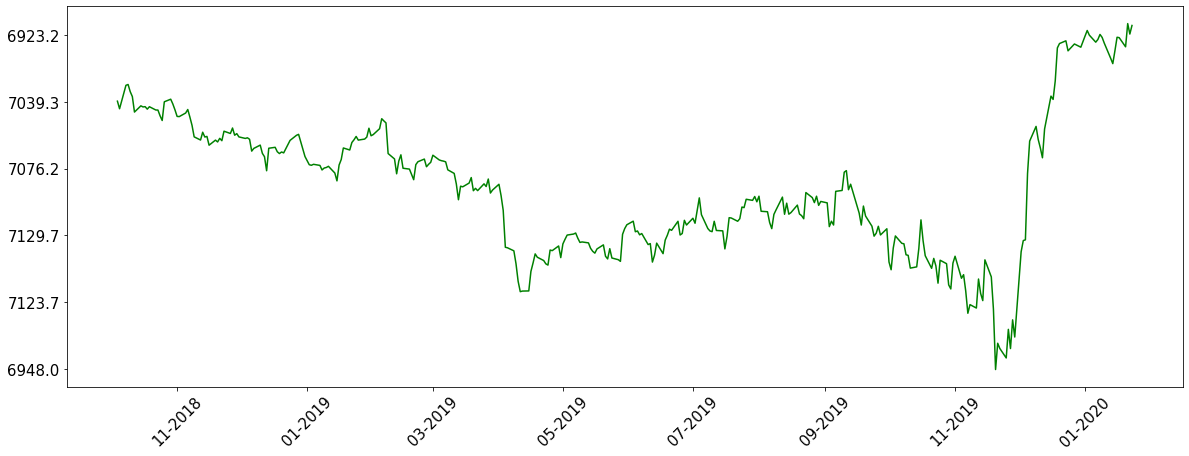

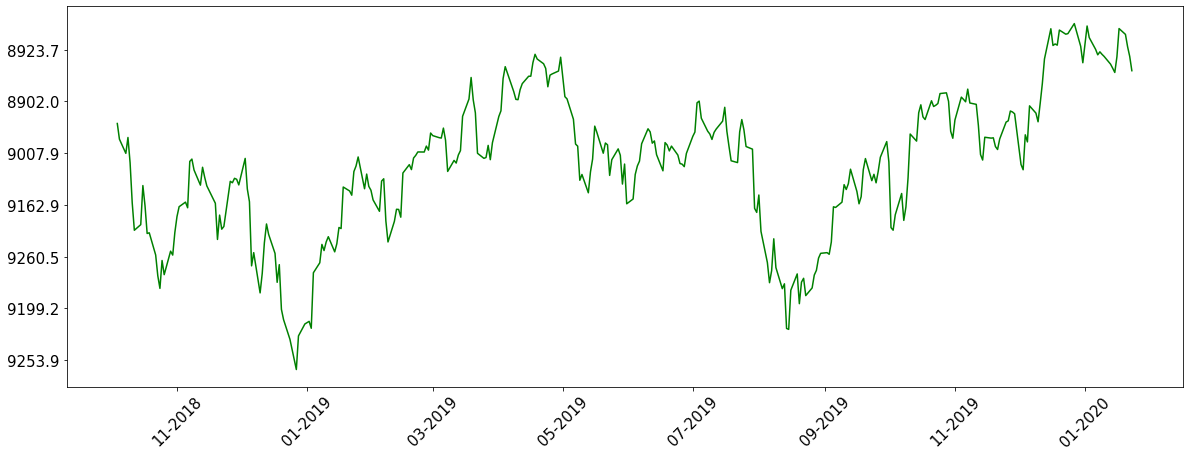

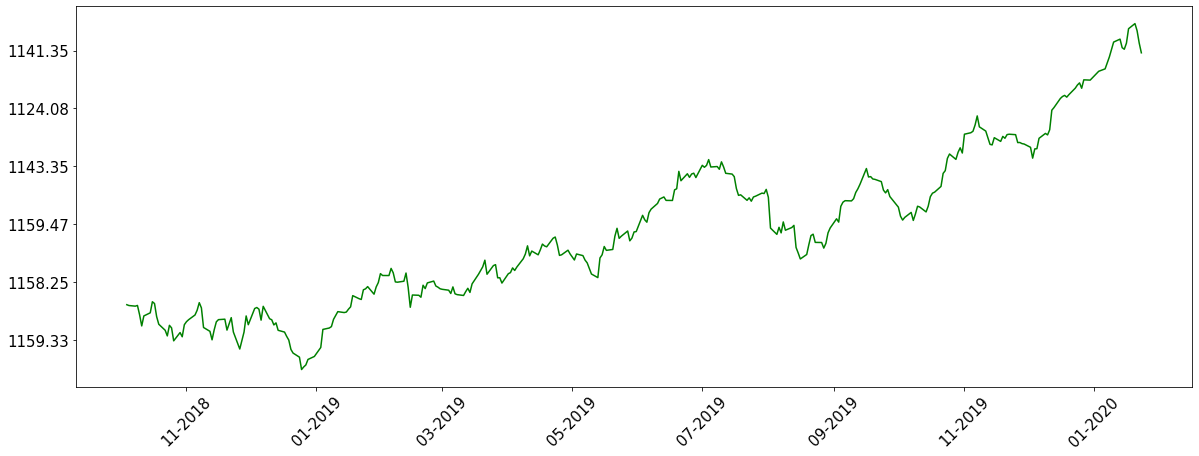

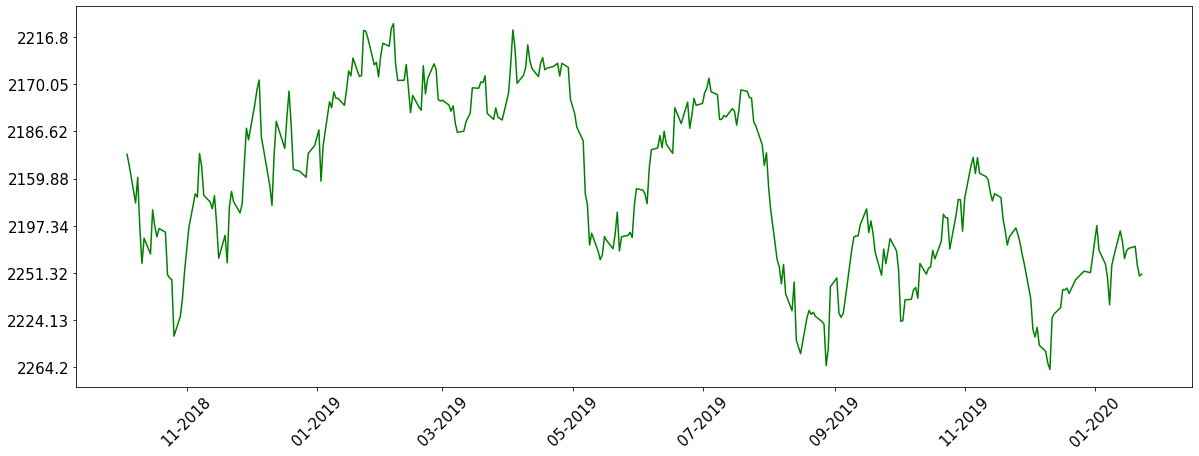

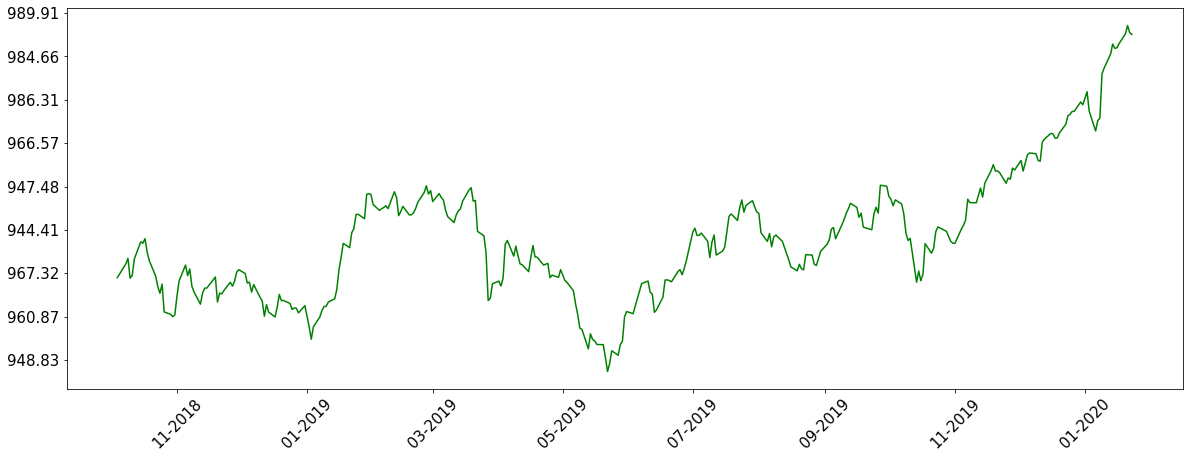

In [ ]:
# Plots for every indexes
for i in calm:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["Zamkniecie"], linestyle='-', color="green")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["Zamkniecie"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

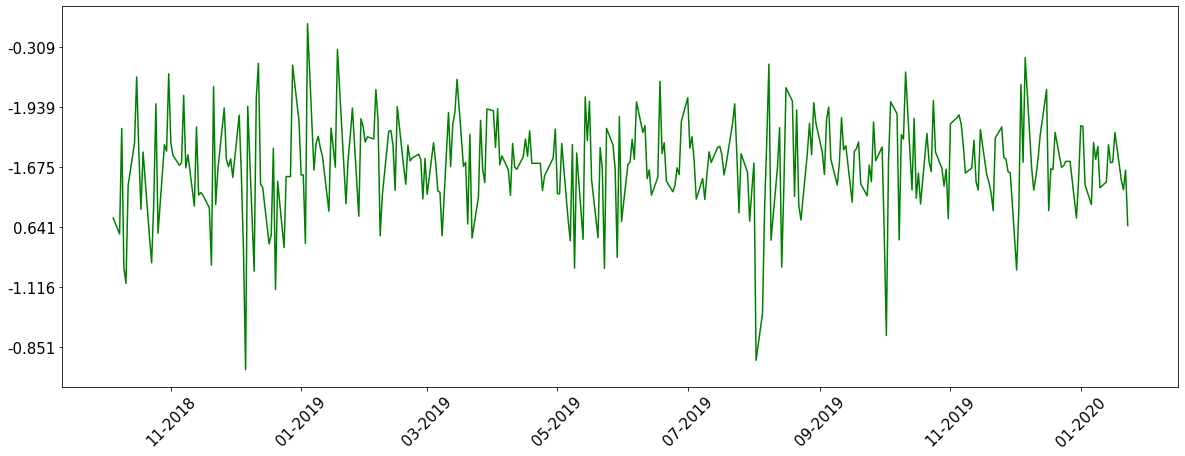

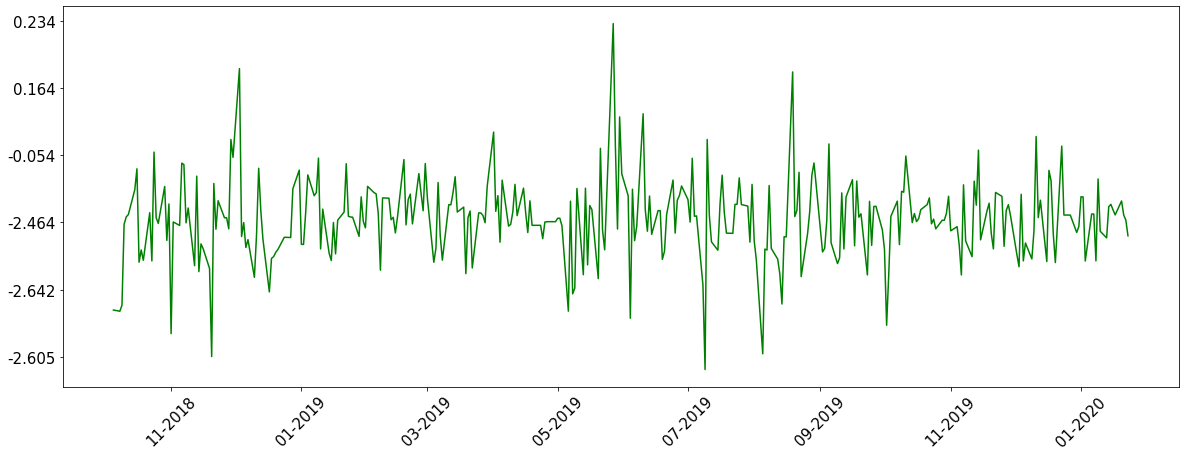

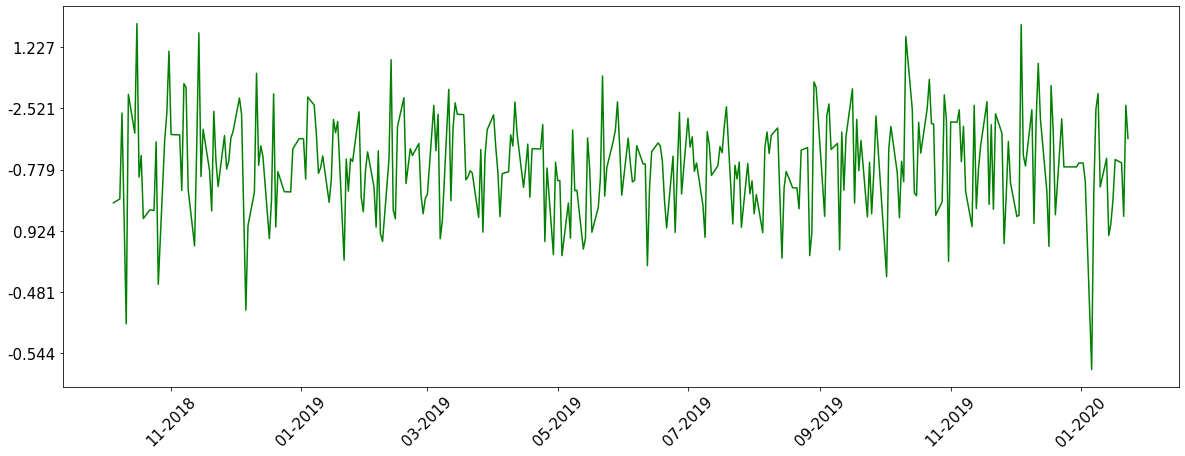

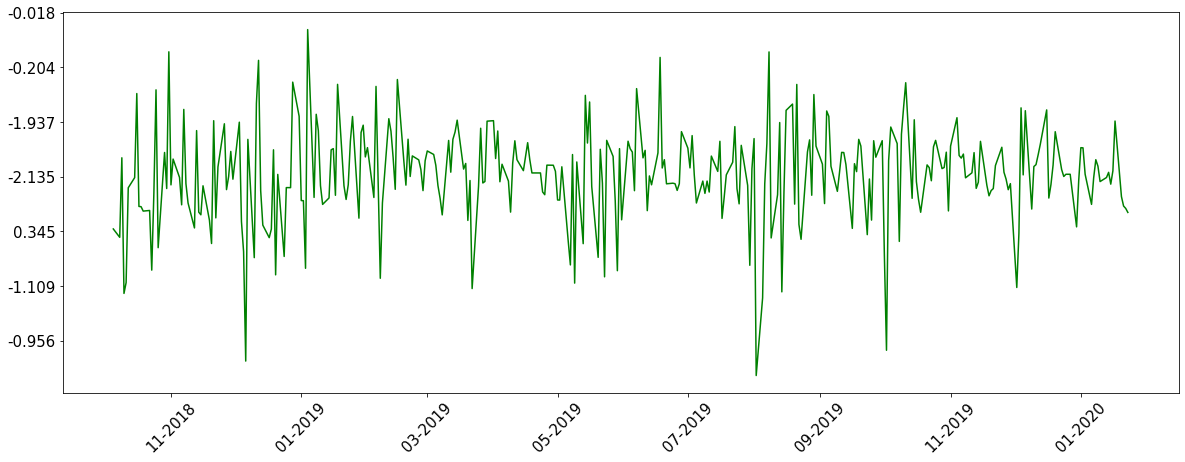

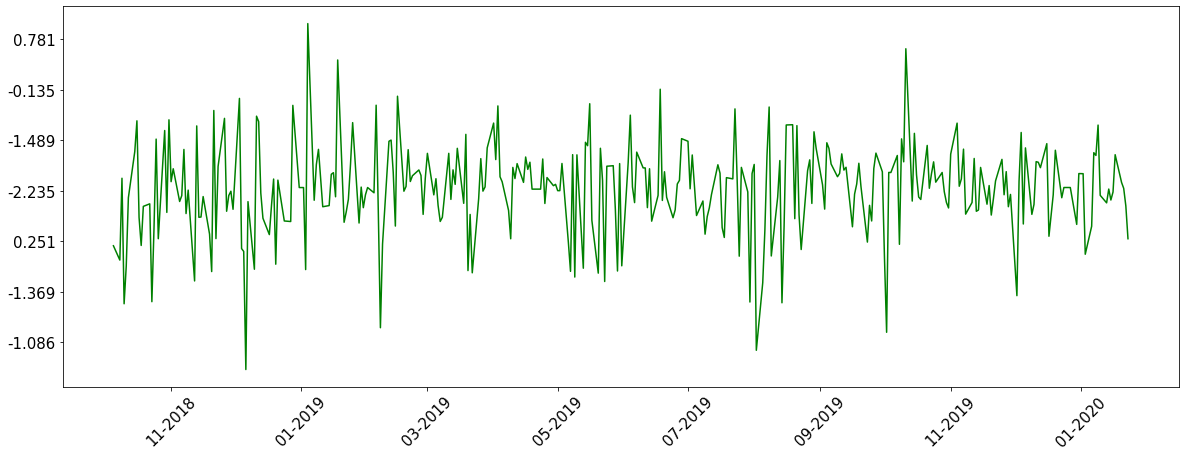

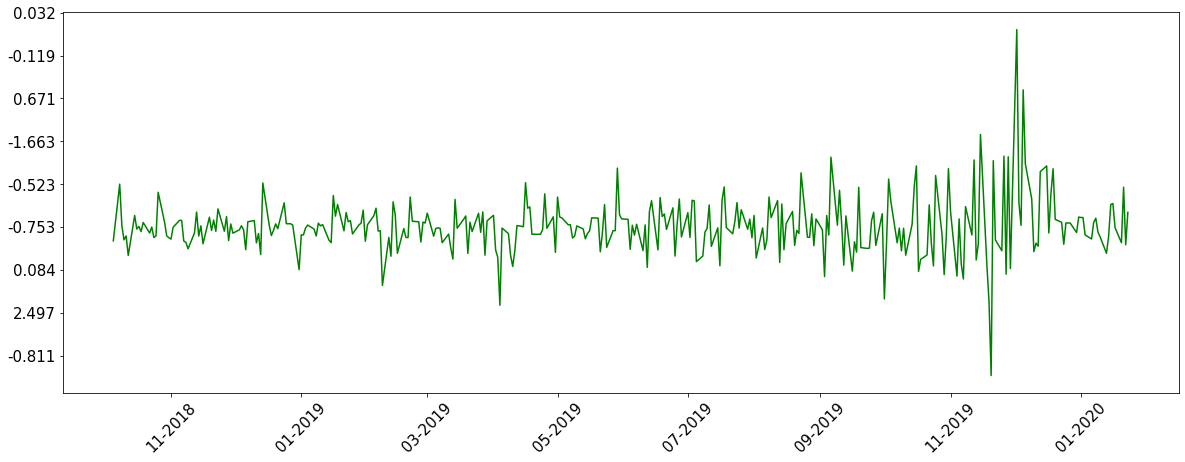

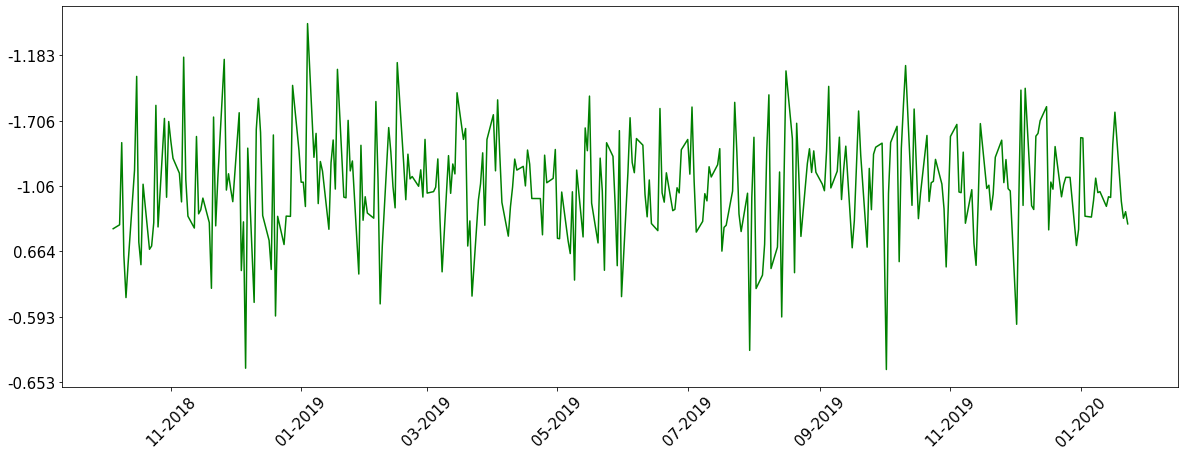

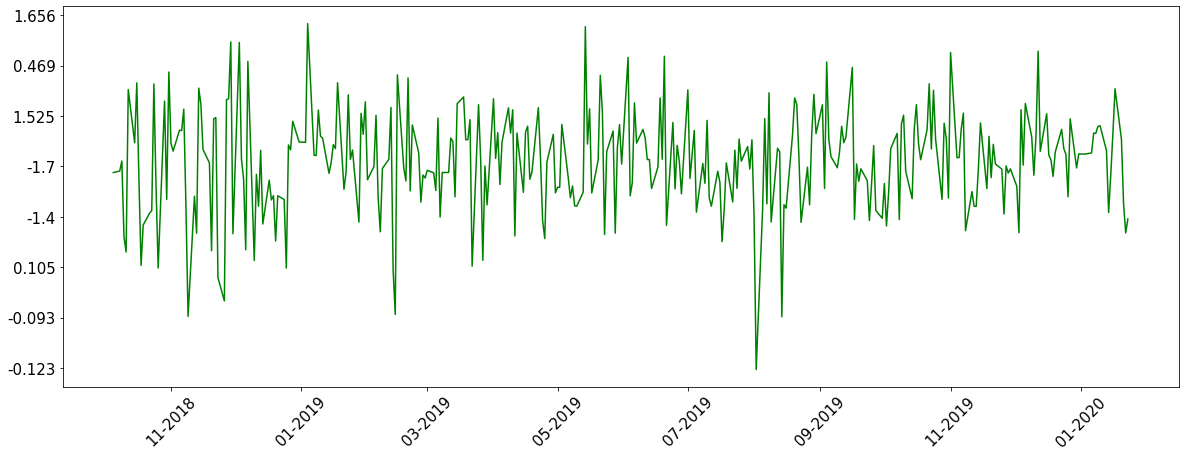

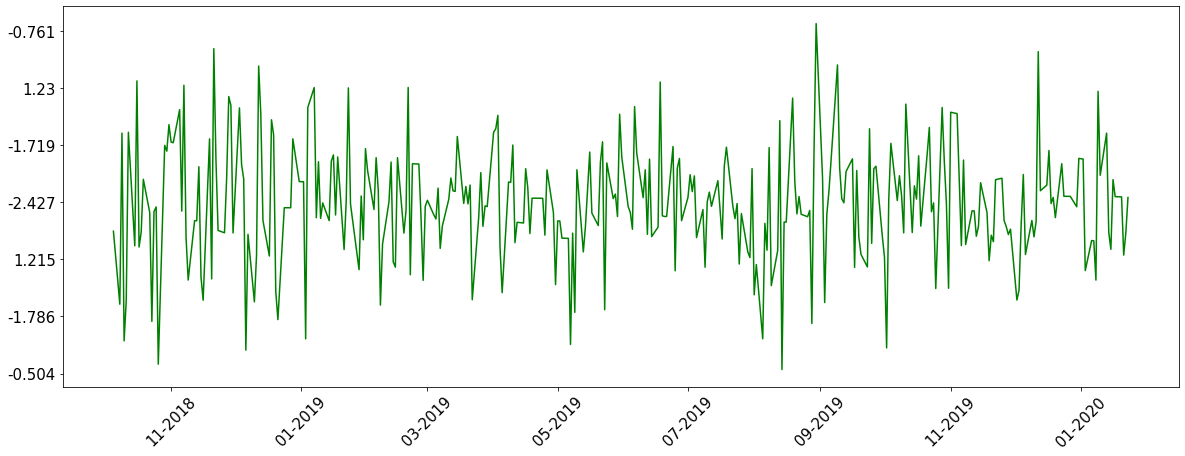

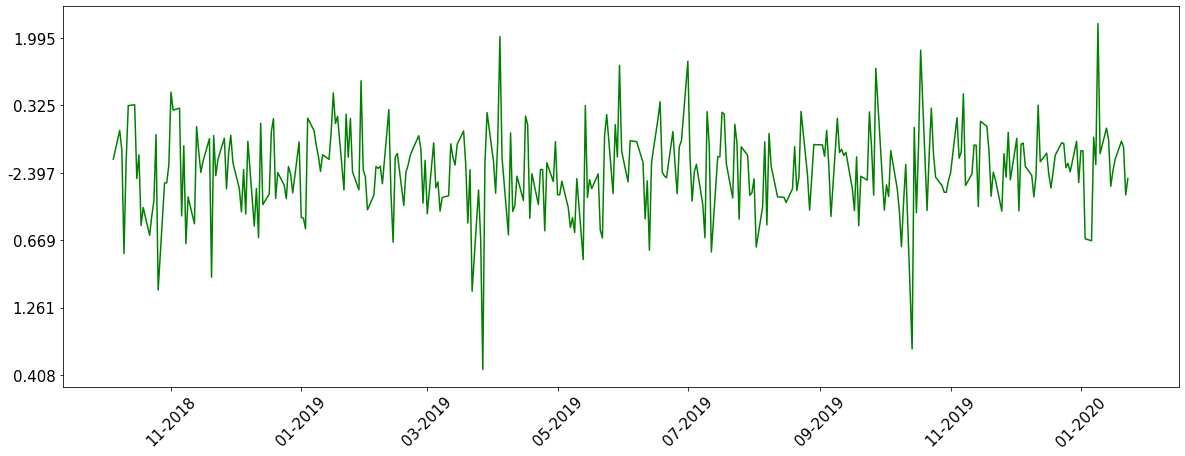

In [ ]:
# Plots for every logarithm's rate retrun indexes
for i in calm:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["log_stopy_zwrotu"], linestyle="-", color="green")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["log_stopy_zwrotu"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

In [ ]:
# Standard deviation for every return rate
std_rr_calm = [i["log_stopy_zwrotu"].std() for i in calm]
print(std_rr_calm)

# Coefficient of variation for every return rate 
coeff_of_var_calm = [i["log_stopy_zwrotu"].std()/i["log_stopy_zwrotu"].mean() for i in calm]
print(coeff_of_var_calm)

[0.7882412500548814, 1.1972805845336867, 0.7992026266125358, 0.8683236665045121, 0.9029417266513928, 1.6674869960956185, 0.8048310763917566, 0.9993544674269176, 0.9964456584188627, 1.2528983426375742]
[25.02752402068324, 12.400588667567858, 14.465059485622023, 29.929896215323588, 34.36209005816922, 72.80017696548131, 126.30659017614369, 10.668333861670964, -58.88166709853639, 16.392288003311975]


**Okres kryzysu od 24 stycznia 2020 do 14 maja 2021 - 341 obserwacji**


In [ ]:
# The crisis time
crisis = [i.loc["2020-01-24":] for i in indexes_interpolation]
print(len(crisis[0]))

341


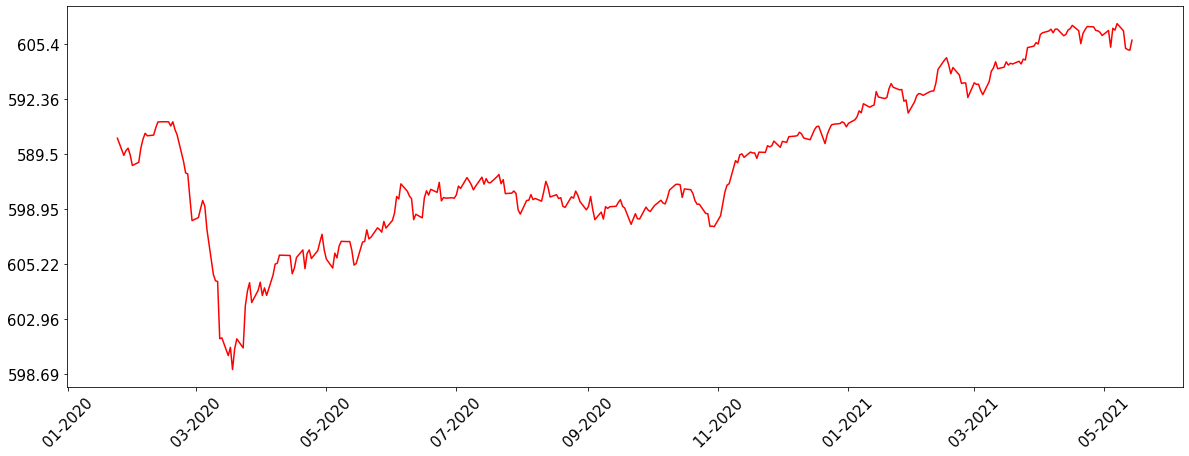

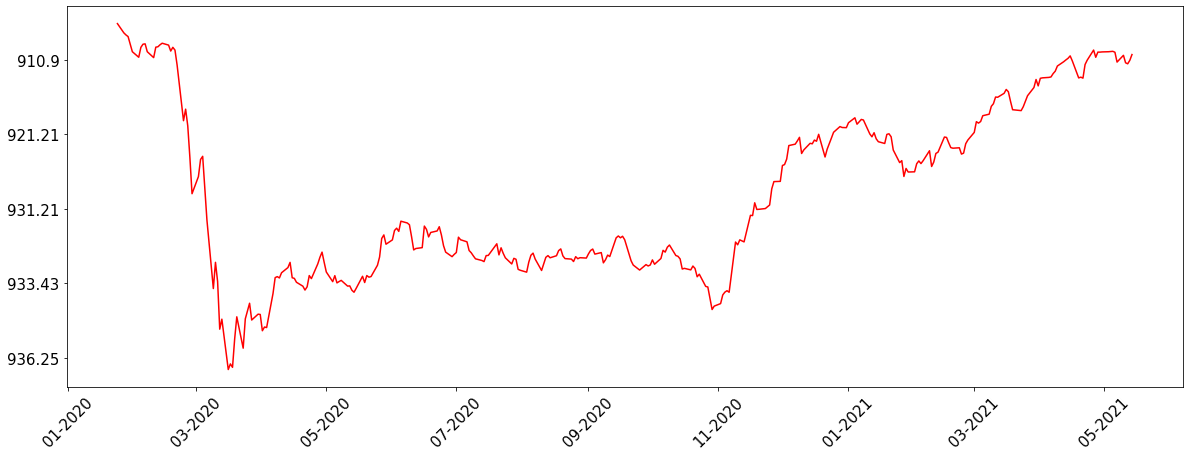

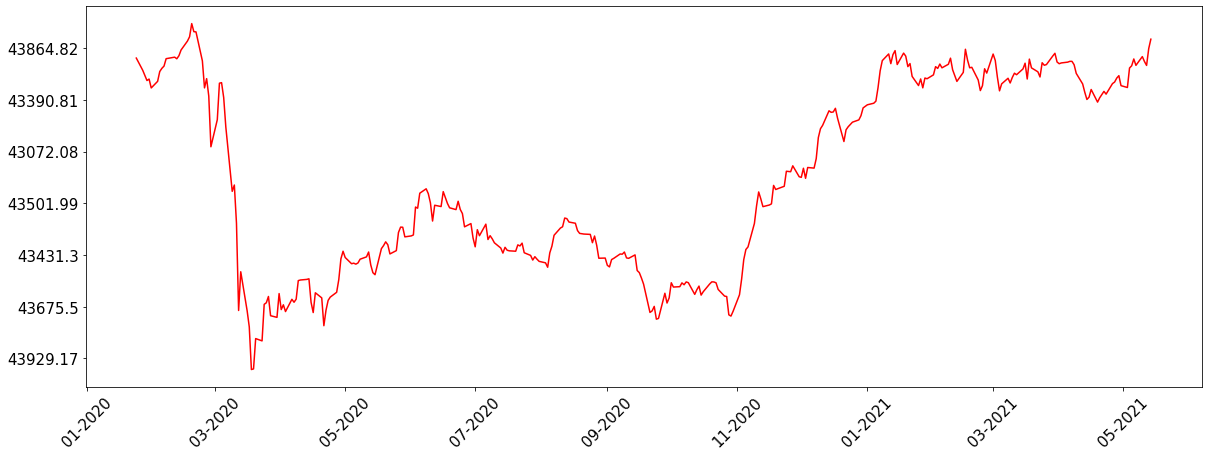

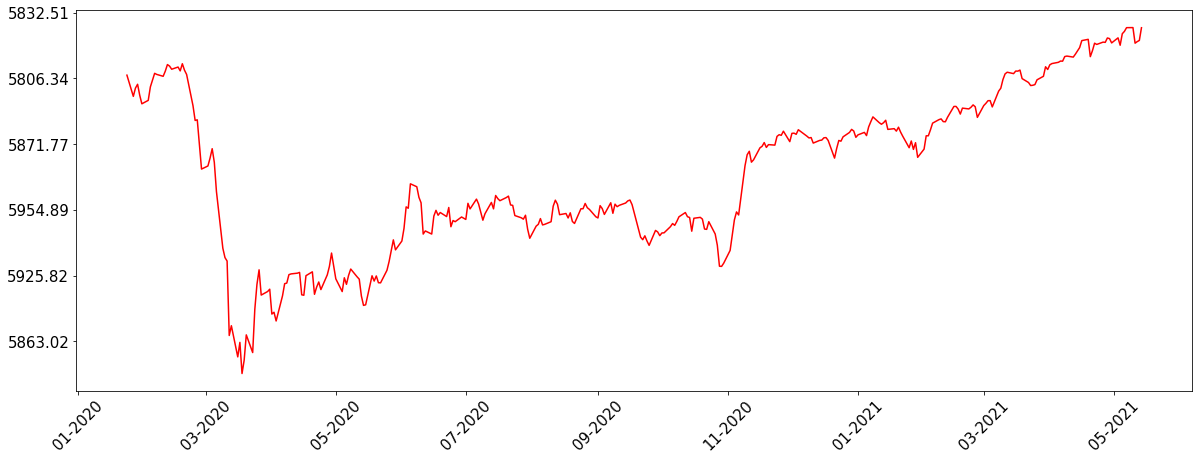

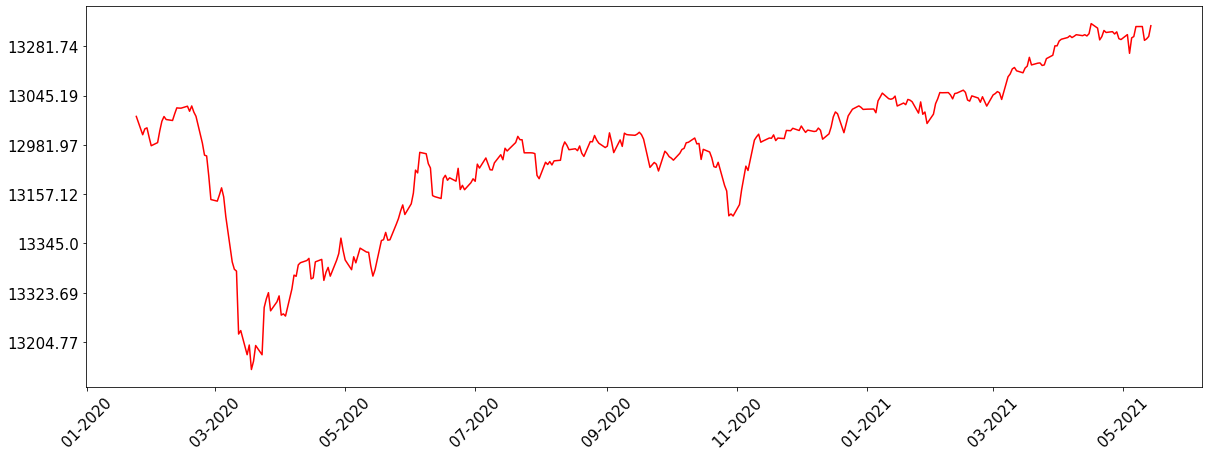

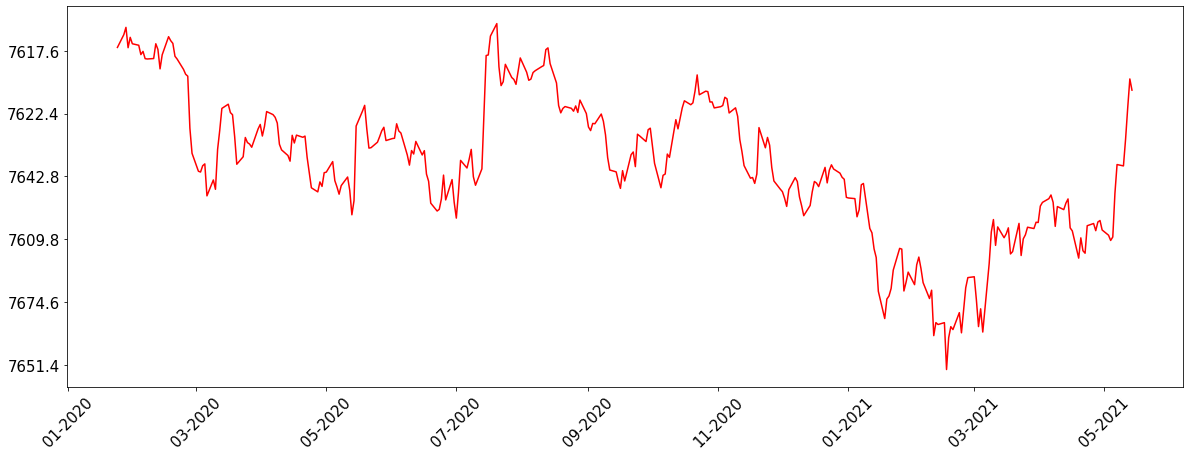

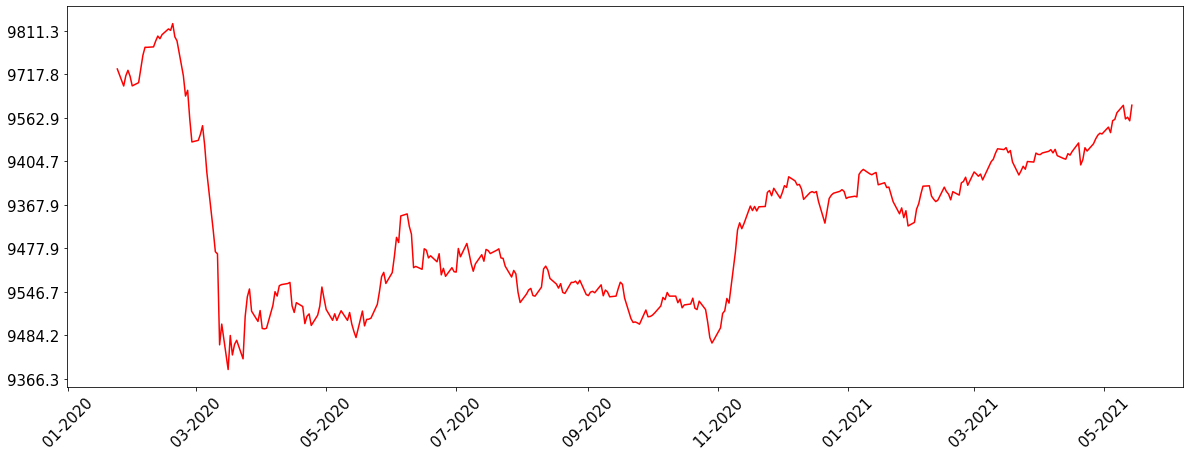

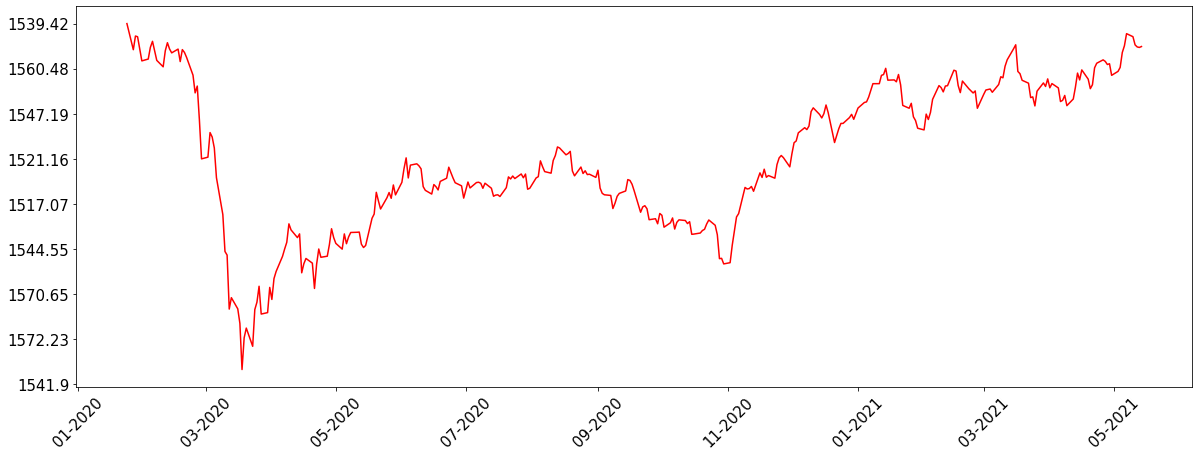

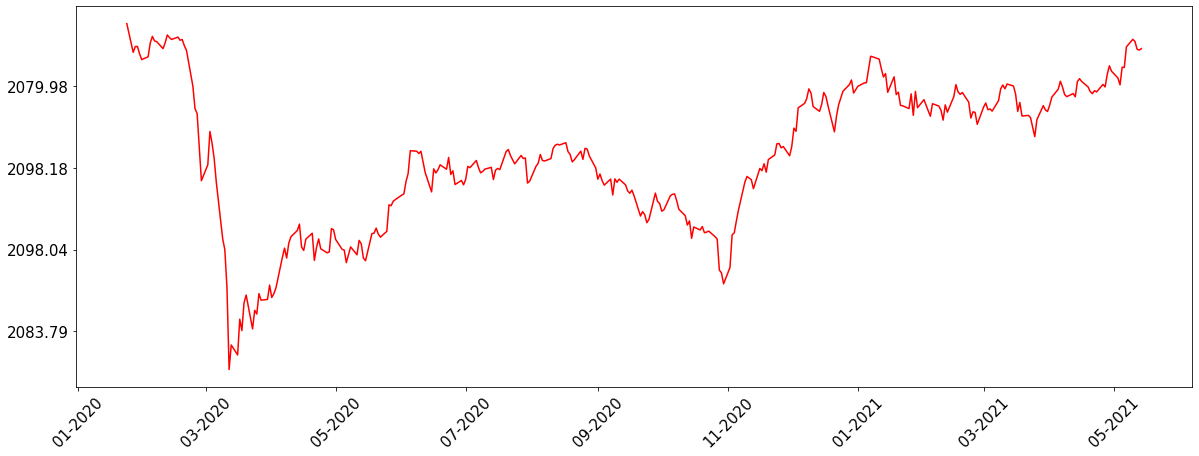

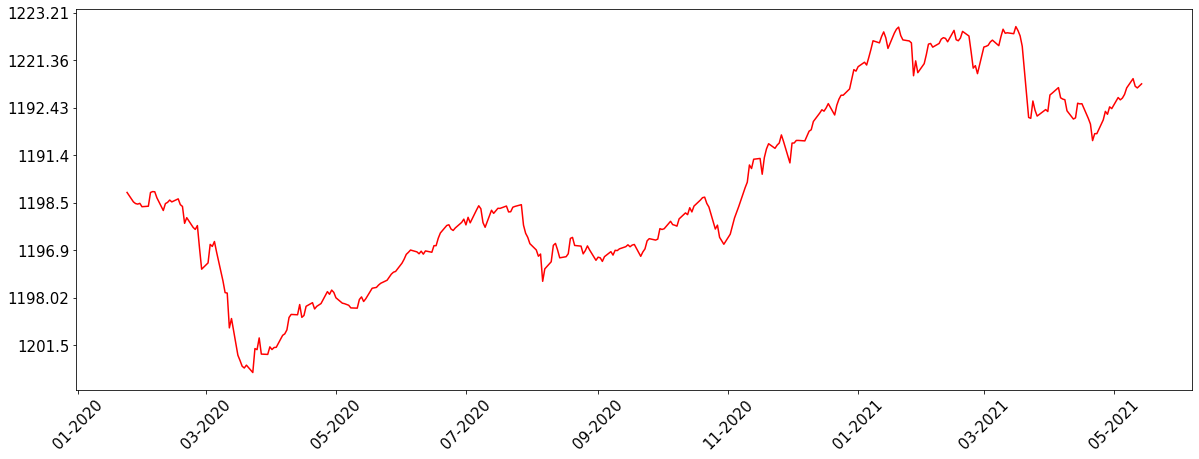

In [ ]:
# Plots for every indexes
for i in crisis:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["Zamkniecie"], linestyle='-', color="red")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["Zamkniecie"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

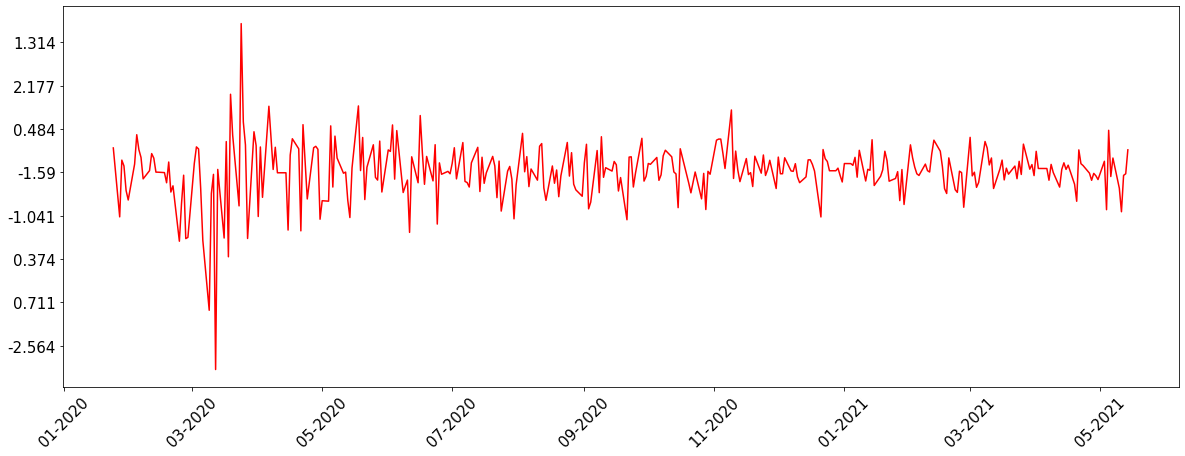

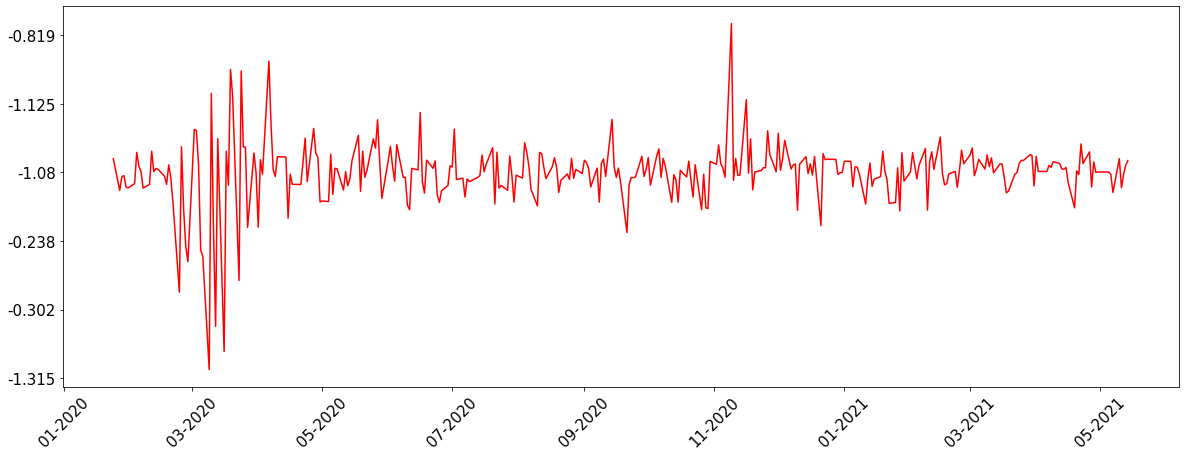

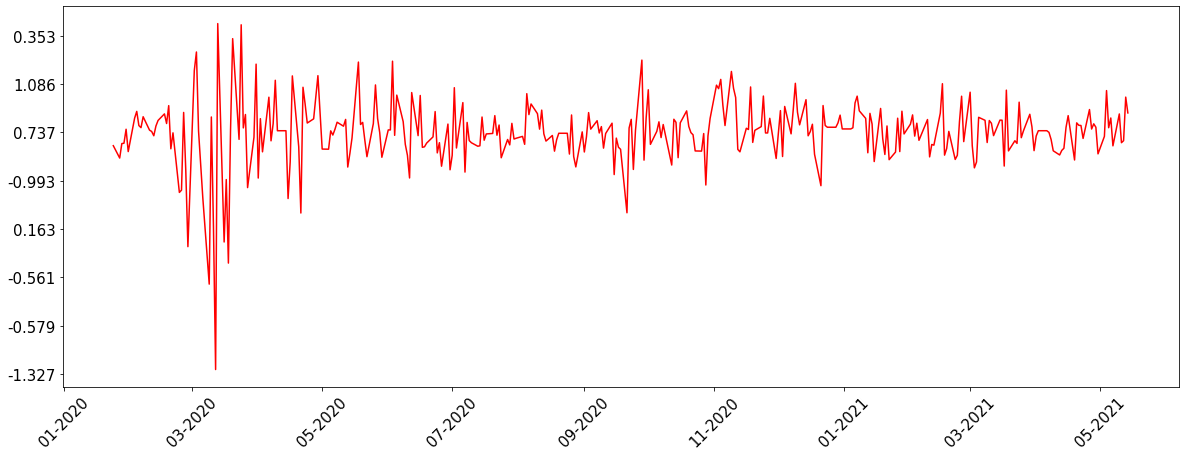

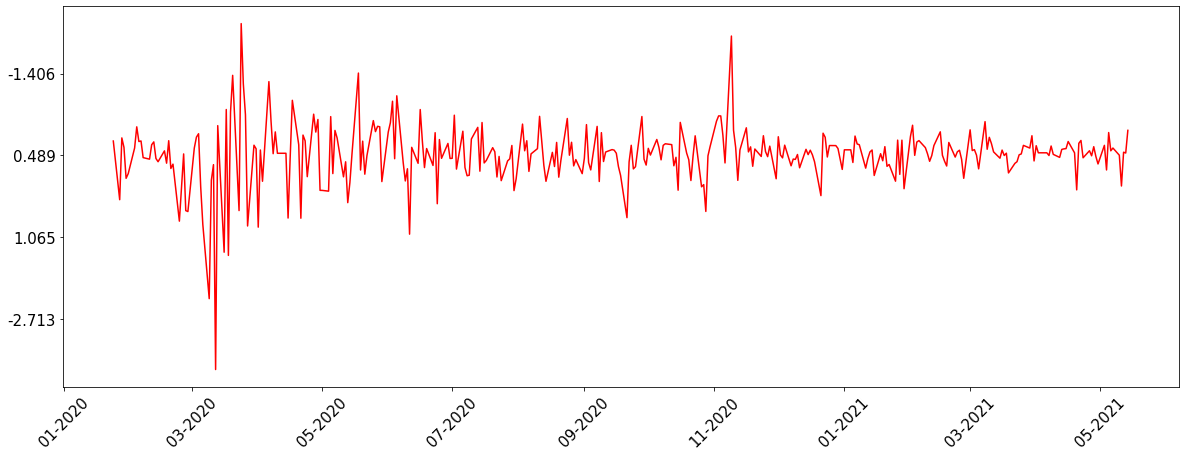

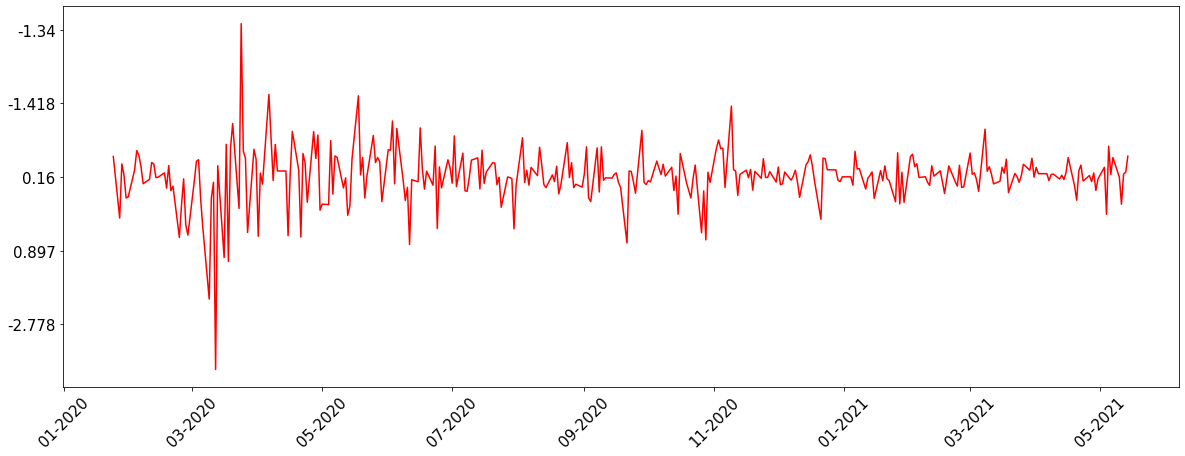

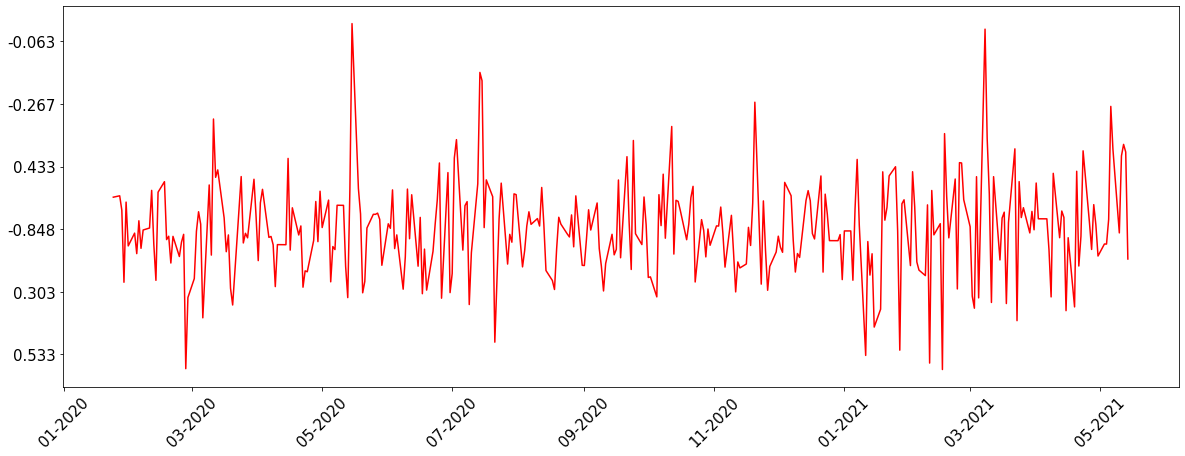

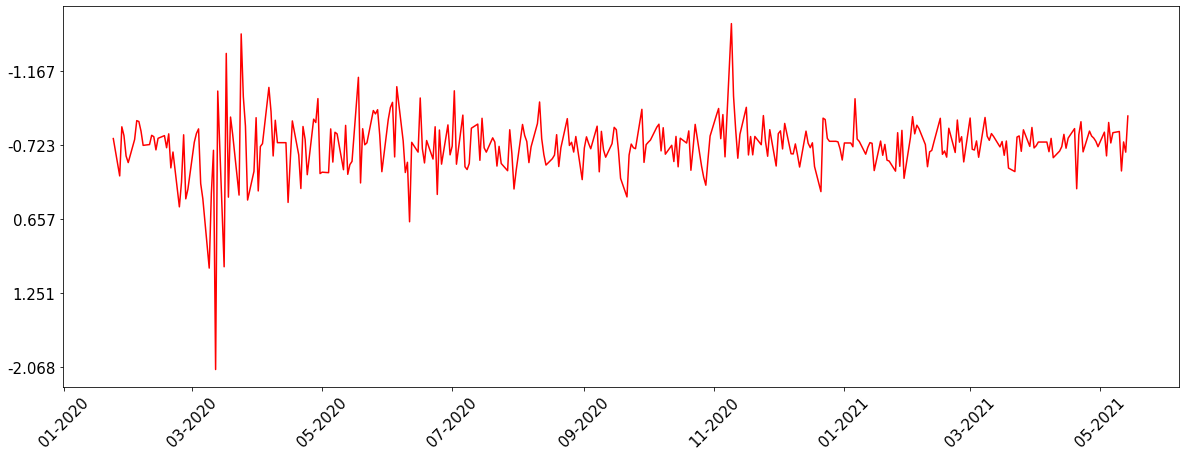

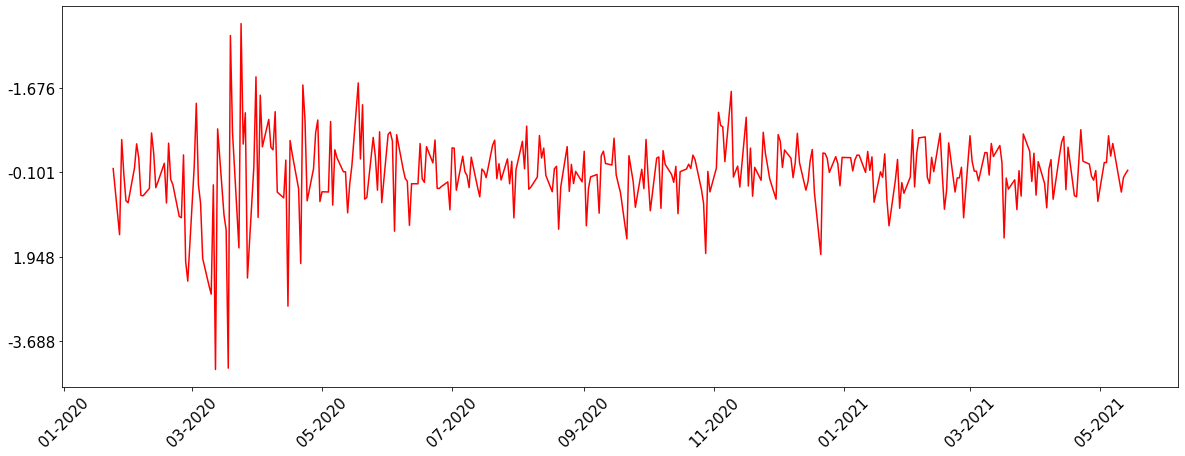

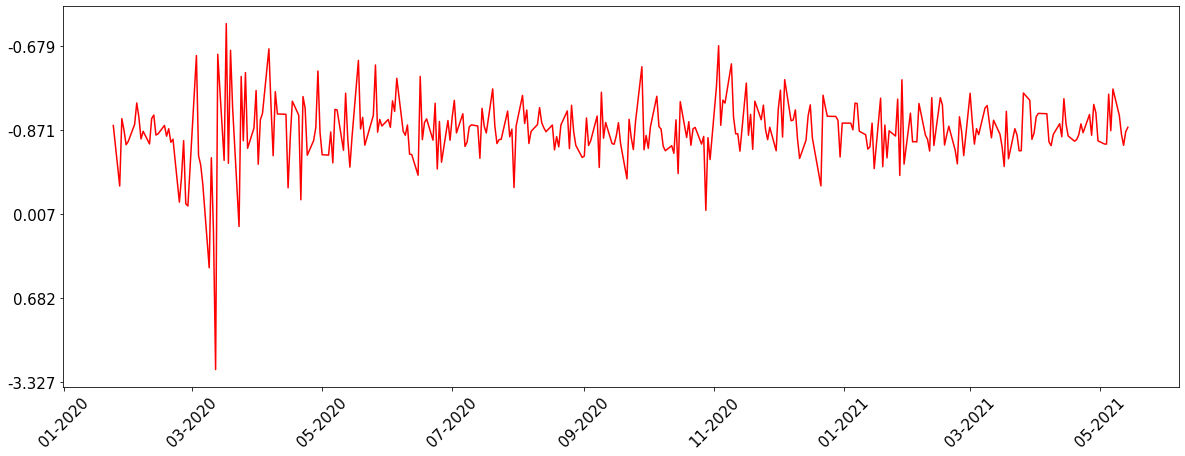

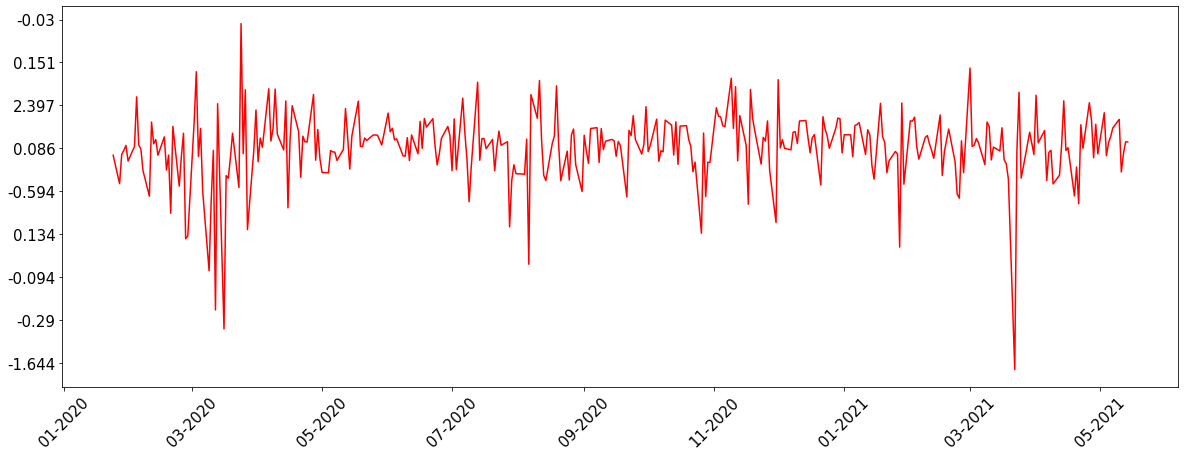

In [ ]:
# Plots for every logarithm's rate retrun indexes
for i in crisis:
  fig, ax = plt.subplots(figsize=(20,7))
  ax.plot(i.index.values, i["log_stopy_zwrotu"], linestyle="-", color="red")
  ax.set_xticklabels(i.index, rotation=45, fontsize=15)
  ax.set_yticklabels(i["log_stopy_zwrotu"].round(3), fontsize=15)
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  plt.show()

In [ ]:
# Standard deviation for every return rate
std_rr_crisis = [i["log_stopy_zwrotu"].std() for i in crisis]
print(std_rr_crisis)

# Coefficient of variation for every return rate 
coeff_of_var_crisis = [i["log_stopy_zwrotu"].std()/i["log_stopy_zwrotu"].mean() for i in crisis]
print(coeff_of_var_crisis)

[1.6220434018233856, 2.292199600938807, 1.6939518047708715, 1.8228274054673268, 1.8478140674929353, 0.7612413938101086, 1.9339918808479835, 2.2096738180647755, 1.8734684764286487, 1.636164429175165]
[36.97960563791541, -224.82979639458327, 430.24885734894036, 92.8753605062556, 44.6701188642904, -200.70739514048003, -165.01974121214698, -251.12399323413337, -243.60307443062817, 33.15993886136208]


In [ ]:
# Standarize of return rate 
standarized = []
for i in range(len(indexes_interpolation)):
  indeks = indexes_interpolation[i]
  indeks["Zestandaryzowane_stopy_zwrotu"] = (indeks['log_stopy_zwrotu'] - indeks['log_stopy_zwrotu'].min())/(indeks['log_stopy_zwrotu'].max() - indeks['log_stopy_zwrotu'].min())
  indeks = indeks["Zestandaryzowane_stopy_zwrotu"]
  standarized.append(indeks)

No handles with labels found to put in legend.


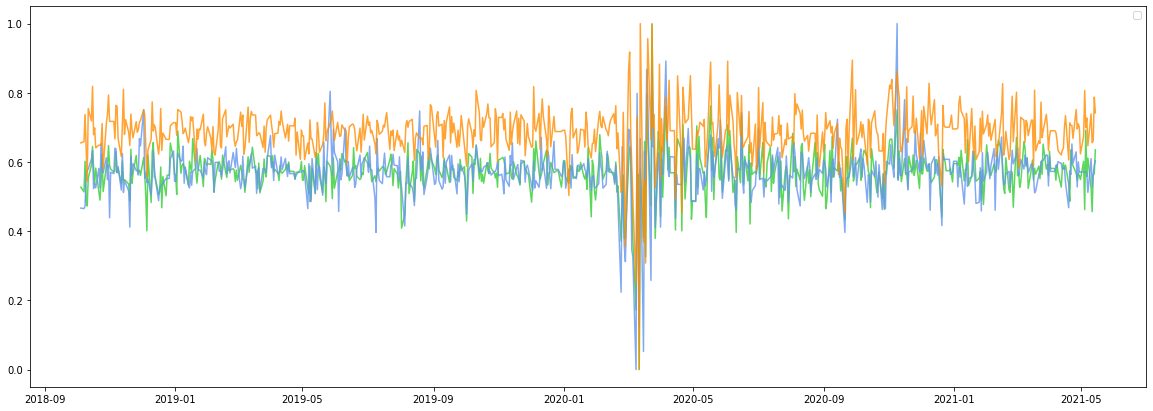

In [ ]:
# Plot of standarized return rates
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(standarized[0], alpha= 0.8, color="limegreen")
ax.plot(standarized[1], color = "cornflowerblue", alpha= 0.8)
ax.plot(standarized[2], color = "darkorange", alpha= 0.8)
plt.legend()
plt.show()

No handles with labels found to put in legend.


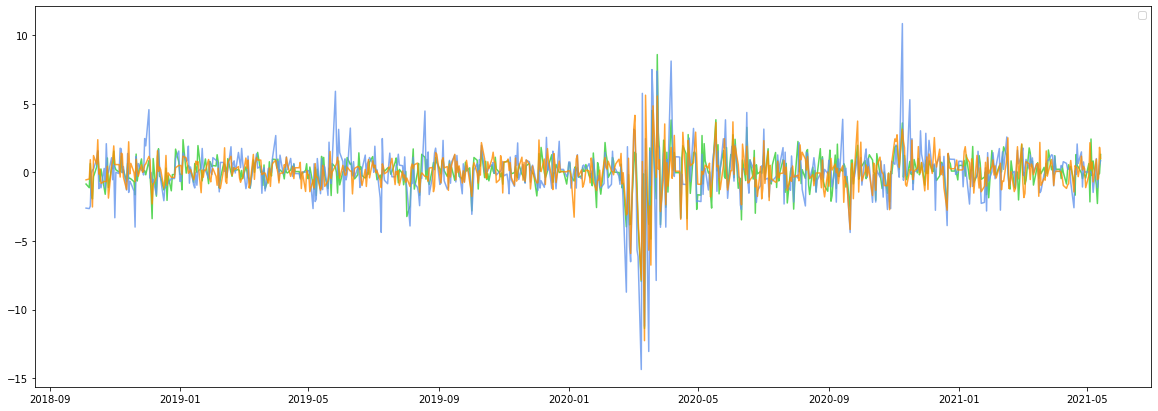

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(indexes_interpolation[0]['log_stopy_zwrotu'], alpha= 0.8, color="limegreen")
ax.plot(indexes_interpolation[1]['log_stopy_zwrotu'], color = "cornflowerblue", alpha= 0.8)
ax.plot(indexes_interpolation[2]['log_stopy_zwrotu'], color = "darkorange", alpha= 0.8)
plt.legend()
plt.show()

In [ ]:
##############################################################################################################################################################

In [ ]:
# Joining all data together
list_return_rates = [i['log_stopy_zwrotu'] for i in indexes_interpolation]
all_indexes = reduce(lambda left, right: pd.merge(left, right, left_on='Data', right_on='Data', how='outer'), list_return_rates)
all_indexes = all_indexes.iloc[1:]
all_indexes.columns = ['aex_nl','ath_el', 'bux_hu', 'cac_fr','dax_de', 'ftse_gb', 'ibex_es', 'rts_ru', 'wig20_pl', 'xu100_tu']

In [ ]:
# Splitting data into calm and crisis period
calm_df = all_indexes.loc[:"2020-01-23"] # 340 length
crisis_df = all_indexes.loc["2020-01-24":] #341 length

# **1. Model VAR:**
* 1.) Przyczynowsość Grangera - podejscie 1 -Granger przed modelem VAR
* 2.) Funkcja odpowiedzi na impuls
* 3.) Współczynnik Pearsona i oczyszczony współczynnik korelacji

**1.1 Model VAR dla całej próby**

In [ ]:
# ADF Stationarity test for all data - H0: występuje pierwiastek jednostkowy --> niestacjo; p <= 0.05 odrzucam H0
adf_results = []
for i in range(len(indexes_interpolation)):
  result = adfuller(indexes_interpolation[i]['log_stopy_zwrotu'].dropna())
  adf_results.append(result)

  print('ADF Statistic: %f' % result[0])
  p_value = result[1]
  print('p-value: %f' % p_value)
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value > 0.05 else ""}stationary')
  print("\n")

ADF Statistic: -5.993620
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -8.675876
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -6.339354
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -5.845276
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -6.092788
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -5.790409
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The index rates of returns are stationary


ADF Statistic: -7.230050
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: T

In [ ]:
# KPSS Stationarity test for all data
kpss_results = []
for i in range(len(indexes_interpolation)):
  result = kpss(indexes_interpolation[i]['log_stopy_zwrotu'].dropna())
  kpss_results.append(result)

  print('KPSS Statistics: %f'% result[0])
  p_value = result[1]
  print('p-value: %f'% p_value)
  print('Critical values:')
  for key, value in result[3].items():
    print('\t%s: %f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value < 0.05 else""}stationary')
  print("\n")

KPSS Statistics: 0.088896
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.087825
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.086089
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.109299
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.090443
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.090368
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index ra

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-valu

In [ ]:
# Granger causality function - ta funkcja jakby robi te modele, że każda zmienna z każdą, wybierane jest najmniejsze pvalue dla opóźnienia do 12
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
  """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
  df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in df.columns:
      for r in df.index:
          test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
          p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
          if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
          min_p_value = np.min(p_values)
          df.loc[r, c] = min_p_value
  df.columns = [var + '_x' for var in variables]
  df.index = [var + '_y' for var in variables]
  return df


In [ ]:
# Granger causality test for all time
grangers_causation_matrix(all_indexes, variables = all_indexes.columns)  

aex_nl_x  ath_el_x  bux_hu_x  cac_fr_x  dax_de_x  ftse_gb_x  ibex_es_x  rts_ru_x  wig20_pl_x  xu100_tu_x
aex_nl_y    1.00e+00  3.00e-04  3.11e-02  1.00e-04  1.10e-03    0.04     0.00e+00   1.68e-02   6.50e-03    2.40e-03 
ath_el_y    2.52e-02  1.00e+00  1.00e-04  3.30e-03  5.50e-03    0.37     0.00e+00   5.80e-03   0.00e+00    2.41e-02 
bux_hu_y    4.30e-03  0.00e+00  1.00e+00  0.00e+00  2.20e-03    0.10     0.00e+00   8.90e-03   1.00e-04    1.17e-01 
cac_fr_y    1.08e-02  0.00e+00  2.24e-01  1.00e+00  1.86e-01    0.18     0.00e+00   2.37e-02   4.60e-03    2.50e-02 
dax_de_y    1.30e-03  0.00e+00  2.40e-02  4.20e-03  1.00e+00    0.13     1.00e-04   5.01e-02   3.30e-03    9.50e-03 
ftse_gb_y   5.14e-01  4.22e-01  4.47e-01  5.92e-01  7.03e-01    1.00     6.11e-01   2.66e-01   3.09e-01    8.31e-01 
ibex_es_y   1.00e-04  0.00e+00  1.10e-03  5.00e-04  1.21e-02    0.19     1.00e+00   3.40e-03   1.93e-02    3.10e-01 
rts_ru_y    6.00e-04  0.00e+00  0.00e+00  0.00e+00  0.00e+00    0.22     0.00e+00   1.00e+00   0.00e+00    1.30e-03 
wig20_pl_y  1.50e-03  0.00e+00  3.00e-04  0.00e+00  8.00e-04    0.07     0.00e+00   2.00e-04   1.00e+00    3.20e-03 
xu100_tu_y  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00    0.54     0.00e+00   3.40e-03   0.00e+00    1.00e+00

**Dla aex_nl** --> przyczyny to wszystkie
**Dla Grecji** --> (tylko nie wielka brytania)

* **Dla Węgier** --> nie wielka brytania i nie turcja
* **Dla Francji** --> nie węgry i nie wielka brytania i nie niemcy, 
* **Dla Niemców** --> nie wielka brytania 
* **Dla GB** --> Nic nie jest przyczyną:)

In [ ]:
# Consider all lags
corr = []
for i in range(0, all_indexes.shape[1]): # wybiera kolumnę która będzie robiłą korelacje
  variable1 = all_indexes.iloc[:,i]
  column_name1 = all_indexes.columns[i]

  for v in range(i+1, all_indexes.shape[1]): # żeby zrobić to z każdym z reszty kolumn
    variable2 = all_indexes.iloc[:,i]
    column_name2 = all_indexes.columns[v]

    for lag in range(1, 360): # liczba opóźnień
      lagged_variable1 = variable1.iloc[lag:]
      lagged_variable2 = variable2.iloc[:-lag]
      correlations = pearsonr(lagged_variable1, lagged_variable2)

      # print('Lag: %s between %s and %s' % (lag, column_name1, column_name2))
      # print(pearsonr(lagged_variable1, lagged_variable2))
      # print('---------')

      if correlations[1] <= 0.05:
        print('\nThe significant correlations (%d) is for lag %s between %s and %s\n' % (correlations[0], lag, column_name1, column_name2))
        print('---------')


In [ ]:
# Fitting the model and choose lag p -- method 1
var_model = VAR(all_indexes)

akkaike = []
for i in range(1,21):
  result = var_model.fit(i)
  print('Lag Order =', i)
  print('AIC : ', result.aic)
  print('BIC : ', result.bic)
  print('FPE : ', result.fpe)
  print('HQIC: ', result.hqic, '\n')
  akkaike.append([i, result.aic])

min_akkaike = (min(akkaike, key=lambda x:x[1]))
print("The minimum Akkaike criterium is for a lag: %d" %min_akkaike[0])

# var_model_fit = var_model.fit(maxlags=60, ic='aic')
# var_model_fit.summary()


Lag Order = 1
AIC :  -1.9236125205994645
BIC :  -1.1920975091307635
FPE :  0.14608242000553376
HQIC:  -1.64046109815109 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


Lag Order = 2
AIC :  -1.9671729923085124
BIC :  -0.5690427466718022
FPE :  0.1398792601246568
HQIC:  -1.4259546605368834 

Lag Order = 3
AIC :  -1.9542233686637547
BIC :  0.11205341490781251
FPE :  0.1417648860535048
HQIC:  -1.1543103573614495 

Lag Order = 4
AIC :  -1.83972513661722
BIC :  0.8962353093119275
FPE :  0.15909701961659006
HQIC:  -0.7804872352366719 

Lag Order = 5
AIC :  -1.8383838219499036
BIC :  1.568803262047008
FPE :  0.15953191485734633
HQIC:  -0.5191883666292081 

Lag Order = 6
AIC :  -1.7763497307708689
BIC :  2.3036128491287506
FPE :  0.1700937994950306
HQIC:  -0.19656159127214679 

Lag Order = 7
AIC :  -1.7155310076553474
BIC :  3.038761839151385
FPE :  0.18128485197968283
HQIC:  0.12548742578505134 

Lag Order = 8
AIC :  -1.6202418952632862
BIC :  3.809941933878215
FPE :  0.20018430581451258
HQIC:  0.4826469346468887 

Lag Order = 9
AIC :  -1.5479890625227517
BIC :  4.559652440269014
FPE :  0.21626524219168736
HQIC:  0.8174127724780309 

Lag Order = 10
AIC :  -1

In [ ]:
# Fitting the model and choose lag p -- method 2
x_var = var_model.select_order(maxlags=21)
x_var.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
# Creating a model with lag = 2
var_model_fitted = var_model.fit(2)
var_model_fitted.summary()

In [ ]:
# Residuals autocorrelations --> NO
var_residuals = var_model_fitted.resid
var_residuals_dw = durbin_watson(var_residuals)
for col, val in zip(all_indexes.columns, var_residuals_dw):
  print(col, ' :', round(val, 2))

aex_nl  : 1.95
ath_el  : 1.98
bux_hu  : 1.98
cac_fr  : 1.94
dax_de  : 1.97
ftse_gb  : 2.0
ibex_es  : 1.95
rts_ru  : 1.99
wig20_pl  : 1.98
xu100_tu  : 2.03


In [ ]:
test_corr = var_model_fitted.test_whiteness(nlags=5, signif=0.05, adjusted=False)

##Print the p-value
##There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

2.7502637282060776e-07

In [ ]:
# Funkcja autokorelacji szeregów czasowych
# var_model_fitted.plot_acorr()

In [ ]:
# Does residuals have normal distribution? --> NO
for i in range(var_residuals.shape[1]):
  statistic, pvalue = stats.normaltest(var_residuals.iloc[:,i])
  print("Statistics = %.3f, p=%.5f" % (statistic,pvalue))
  alpha = 0.05
  if  pvalue > alpha:
     print('Data looks Gaussian (fail to reject null hypothesis)')
  else:
     print('Data looks non-Gaussian (reject null hypothesis')

In [ ]:
# y_fitted = var_model_fitted.fittedvalues
# plt.figure(figsize = (15,5))
# #plt.plot(var_model_fit.resid, label='resid')
# plt.plot(y_fitted, label='VAR prediction')
# plt.xlabel('Date')
# plt.xticks(rotation=45)
# plt.ylabel('Residuals')
# plt.grid(True)

### **Impulse Response Analysis**

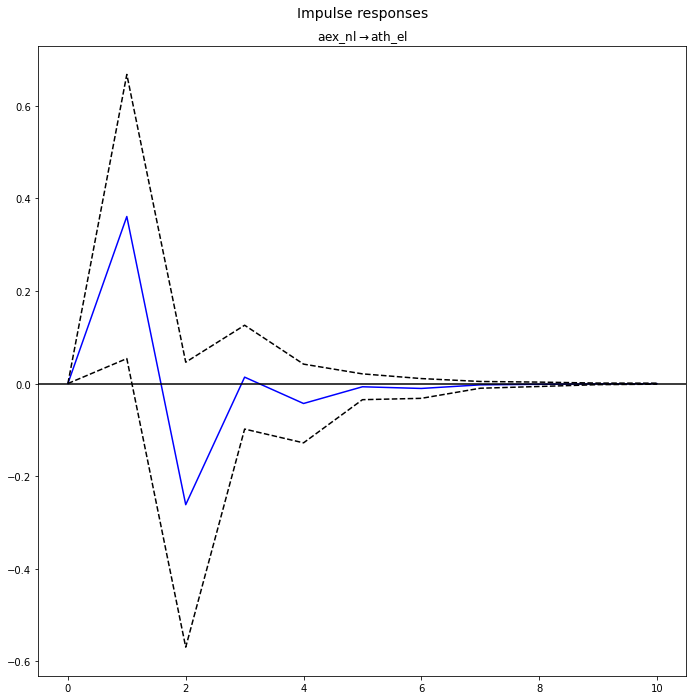

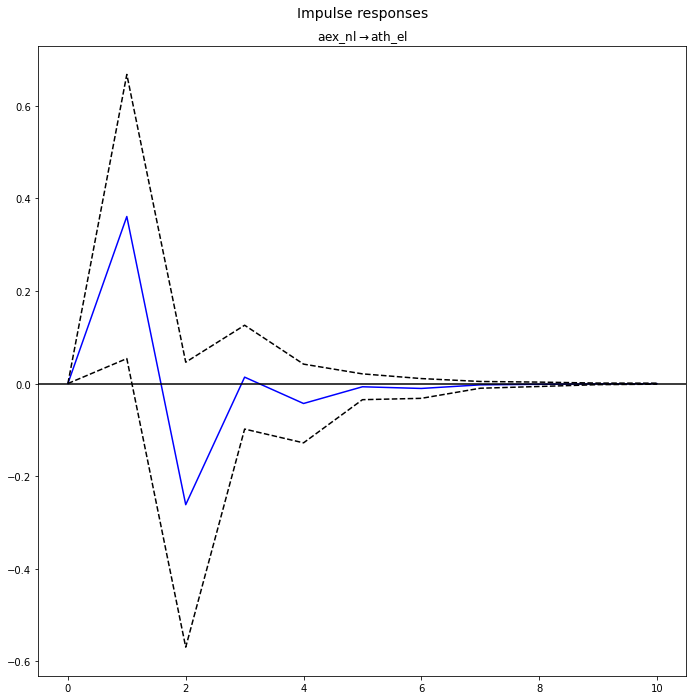

In [ ]:
irf = var_model_fitted.irf(10)
irf.plot(impulse='aex_nl', response='ath_el') # impulse --> to co wywoła szok i zobaczymy odpowiedź grecji na szok wywołany przez holandię

#**1.2 VAR model for 1 sub-sample - time of peace**

In [ ]:
# ADF Stationarity test for calm_df - H0: występuje pierwiastek jednostkowy --> niestacjo; p <= 0.05 odrzucam H0
calm_adf_results = []
for column in range(calm_df.shape[1]):
  result = adfuller(calm_df.iloc[:,column])
  calm_adf_results.append(result)

  print('ADF Statistic: %f' % result[0])
  p_value = result[1]
  print('p-value: %f' % p_value)
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value > 0.05 else ""}stationary')
  print("\n")

In [ ]:
# KPSS Stationarity test for calm_df
calm_kpss_results = []
for column in range(calm_df.shape[1]):
  result = kpss(calm_df.iloc[:,column])
  calm_kpss_results.append(result)

  print('KPSS Statistics: %f'% result[0])
  p_value = result[1]
  print('p-value: %f'% p_value)
  print('Critical values:')
  for key, value in result[3].items():
    print('\t%s: %f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value < 0.05 else""}stationary')
  print("\n")

KPSS Statistics: 0.118280
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.119549
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.076862
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.183291
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.231560
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.255882
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index ra

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-valu

**Podejście 1 - Granger przed modelem VAR**

In [ ]:
grangers_causation_matrix(calm_df, variables = calm_df.columns)  

aex_nl_x  ath_el_x  bux_hu_x  cac_fr_x  dax_de_x  ftse_gb_x  ibex_es_x  rts_ru_x  wig20_pl_x  xu100_tu_x
aex_nl_y      1.00      0.50      0.37    1.07e-01  2.35e-01    0.20     4.95e-02     0.19     1.51e-02      0.03   
ath_el_y      0.05      1.00      0.14    5.34e-02  1.21e-01    0.63     1.23e-01     0.04     1.00e-04      0.09   
bux_hu_y      0.18      0.01      1.00    6.71e-02  5.80e-03    0.15     2.12e-02     0.03     4.57e-01      0.03   
cac_fr_y      0.05      0.77      0.13    1.00e+00  3.99e-01    0.44     1.70e-01     0.30     2.19e-02      0.10   
dax_de_y      0.29      0.26      0.19    3.49e-01  1.00e+00    0.29     3.58e-01     0.12     3.30e-03      0.10   
ftse_gb_y     0.40      0.28      0.08    5.31e-01  7.24e-01    1.00     3.87e-01     0.40     1.86e-01      0.80   
ibex_es_y     0.05      0.39      0.42    2.32e-01  3.72e-01    0.13     1.00e+00     0.48     4.14e-02      0.09   
rts_ru_y      0.20      0.42      0.32    1.71e-01  3.54e-02    0.15     2.26e-02     1.00     1.27e-01      0.14   
wig20_pl_y    0.01      0.01      0.14    2.40e-03  4.50e-03    0.04     4.60e-03     0.11     1.00e+00      0.37   
xu100_tu_y    0.17      0.28      0.28    4.06e-01  1.42e-01    0.50     4.56e-02     0.02     2.47e-01      1.00

* Dla aex_nl --> przyczyna to tylko hiszpania, polska, turcja
* Dla Grecji --> przyczyna, rosja i polska
* Dla Węgier --> przyczyna to holandia, grecja, niemcy, hiszpania, rosja turcja
* Dla Francji --> przyczyna to polska XD
* Dla Niemców --> przyczyna to polska XD
* Dla GB --> Nic nie jest przyczyną:)
* Dla Polski --> Holandia, grecja,  gfrancja, niemcy, gb i hiszpania

In [ ]:
# Fitting the model and choose lag p -- method 1
calm_var = VAR(calm_df)

calm_akkaike = []
for i in range(1,14):
  result = calm_var.fit(i)
  print('Lag Order =', i)
  print('AIC : ', result.aic)
  print('BIC : ', result.bic)
  print('FPE : ', result.fpe)
  print('HQIC: ', result.hqic, '\n')
  calm_akkaike.append([i, result.aic])

calm_min_akkaike = (min(calm_akkaike, key=lambda x:x[1]))
print("The minimum Akkaike criterium is for a lag: %d" %calm_min_akkaike[0])

Lag Order = 1
AIC :  -6.416265308861756
BIC :  -5.174790347764855
FPE :  0.0016351227524647827
HQIC:  -5.921537435902853 

Lag Order = 2
AIC :  -6.147239224243015
BIC :  -3.7719740229074117
FPE :  0.002142811283004345
HQIC:  -5.200594670027472 

Lag Order = 3
AIC :  -5.8930969342540855
BIC :  -2.379074060636187
FPE :  0.0027728456285695327
HQIC:  -4.492458961782798 

Lag Order = 4
AIC :  -5.701395763668749
BIC :  -1.043611312523172
FPE :  0.003382386873693214
HQIC:  -3.8446722669961497 

Lag Order = 5
AIC :  -5.506835450494891
BIC :  0.2997513292984948
FPE :  0.004156922521932512
HQIC:  -3.191918799024629 

Lag Order = 6
AIC :  -5.324025179087551
BIC :  1.63644190389385
FPE :  0.005079308784441612
HQIC:  -2.5487920598723957 

Lag Order = 7
AIC :  -5.172055252935117
BIC :  2.947407713689854
FPE :  0.006062604563989827
HQIC:  -1.9343665109502588 

Lag Order = 8
AIC :  -5.006870767192112
BIC :  4.276741656971607
FPE :  0.0073987641373271865
HQIC:  -1.3045712435504413 

Lag Order = 9
AIC :

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [ ]:
# Fitting the VAR model and choose lag p -- method 2
calm_x_var = calm_var.select_order(maxlags=21)
calm_x_var.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
# Creating a model with lag = 1
calm_model_var = calm_var.fit(1)
calm_model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jul, 2021
Time:                     17:09:47
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.17479
Nobs:                     339.000    HQIC:                  -5.92154
Log likelihood:          -3612.64    FPE:                 0.00163512
AIC:                     -6.41627    Det(Omega_mle):      0.00118814
--------------------------------------------------------------------
Results for equation aex_nl
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.013276         0.043180            0.307           0.758
L1.aex_nl          -0.108754         0.153567           -0.708           0.479
L1.ath_el           0.024231         0.039790            0.609     

In [ ]:
# Residuals autocorrelation -- NO AUTOCORR
calm_residuals = calm_model_var.resid
calm_residuals_dw = durbin_watson(calm_residuals)
for col, val in zip(calm_df.columns, calm_residuals_dw):
  print(col, ' :', round(val, 2))

aex_nl  : 2.01
ath_el  : 2.01
bux_hu  : 1.99
cac_fr  : 2.0
dax_de  : 2.0
ftse_gb  : 1.97
ibex_es  : 1.99
rts_ru  : 2.01
wig20_pl  : 2.0
xu100_tu  : 2.0


In [ ]:
# Does residuals have normal distribution? --> NO
for i in range(calm_residuals.shape[1]):
  statistic, pvalue = stats.normaltest(calm_residuals.iloc[:,i])
  print("Statistics = %.3f, p=%.5f" % (statistic,pvalue))
  alpha = 0.05
  if  pvalue > alpha:
     print('Data looks Gaussian (fail to reject null hypothesis)')
  else:
     print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 31.651, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 29.205, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 5.104, p=0.07792
Data looks Gaussian (fail to reject null hypothesis)
Statistics = 30.074, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 19.457, p=0.00006
Data looks non-Gaussian (reject null hypothesis
Statistics = 109.381, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 6.656, p=0.03587
Data looks non-Gaussian (reject null hypothesis
Statistics = 14.495, p=0.00071
Data looks non-Gaussian (reject null hypothesis
Statistics = 1.573, p=0.45546
Data looks Gaussian (fail to reject null hypothesis)
Statistics = 24.681, p=0.00000
Data looks non-Gaussian (reject null hypothesis


**1.3 VAR model for 2 sub-sample - time of crisis**

In [ ]:
# ADF Stationarity test for crisis_df - H0: występuje pierwiastek jednostkowy --> niestacjo; p <= 0.05 odrzucam H0
crisis_adf_results = []
for column in range(crisis_df.shape[1]):
  result = adfuller(crisis_df.iloc[:,column])
  crisis_adf_results.append(result)

  print('ADF Statistic: %f' % result[0])
  p_value = result[1]
  print('p-value: %f' % p_value)
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value > 0.05 else ""}stationary')
  print("\n")

ADF Statistic: -4.941307
p-value: 0.000029
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: The index rates of returns are stationary


ADF Statistic: -5.987558
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: The index rates of returns are stationary


ADF Statistic: -3.663622
p-value: 0.004655
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572
Result: The index rates of returns are stationary


ADF Statistic: -6.618475
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: The index rates of returns are stationary


ADF Statistic: -5.586466
p-value: 0.000001
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: The index rates of returns are stationary


ADF Statistic: -17.036942
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: The index rates of returns are stationary


ADF Statistic: -4.850153
p-value: 0.000044
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
Result: 

In [ ]:
# KPSS Stationarity test for crisis data
crisis_kpss_results = []
for column in range(crisis_df.shape[1]):
  result = kpss(crisis_df.iloc[:,column])
  crisis_kpss_results.append(result)

  print('KPSS Statistics: %f'% result[0])
  p_value = result[1]
  print('p-value: %f'% p_value)
  print('Critical values:')
  for key, value in result[3].items():
    print('\t%s: %f' % (key, value))
  print(f'Result: The index rates of returns are {"not " if p_value < 0.05 else""}stationary')
  print("\n")

KPSS Statistics: 0.153421
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.311266
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.267662
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.241769
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.135333
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index rates of returns are stationary


KPSS Statistics: 0.143762
p-value: 0.100000
Critical values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: The index ra

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-valu

In [ ]:
grangers_causation_matrix(crisis_df, variables = crisis_df.columns)  

aex_nl_x  ath_el_x  bux_hu_x  cac_fr_x  dax_de_x  ftse_gb_x  ibex_es_x  rts_ru_x  wig20_pl_x  xu100_tu_x
aex_nl_y    1.00e+00  4.00e-04  1.20e-01  1.00e-04  9.00e-04  2.80e-03   0.00e+00   3.56e-02   1.78e-02    2.68e-02 
ath_el_y    3.53e-02  1.00e+00  1.40e-03  1.80e-03  6.30e-03  1.66e-02   0.00e+00   6.45e-02   3.40e-03    7.71e-02 
bux_hu_y    5.00e-03  0.00e+00  1.00e+00  0.00e+00  1.00e-03  2.40e-03   0.00e+00   3.87e-02   5.00e-04    1.82e-01 
cac_fr_y    9.20e-03  0.00e+00  1.99e-01  1.00e+00  8.35e-02  7.40e-03   0.00e+00   6.18e-02   2.60e-03    6.88e-02 
dax_de_y    6.00e-04  0.00e+00  7.60e-02  1.42e-02  1.00e+00  1.80e-03   1.02e-02   1.08e-01   5.30e-03    1.81e-02 
ftse_gb_y   2.30e-01  4.70e-01  2.86e-01  4.25e-01  3.53e-01  1.00e+00   5.33e-01   8.83e-02   1.08e-01    5.01e-01 
ibex_es_y   5.00e-04  0.00e+00  1.70e-03  6.00e-04  5.39e-02  5.70e-03   1.00e+00   1.46e-02   4.50e-03    3.18e-01 
rts_ru_y    5.10e-03  0.00e+00  0.00e+00  6.00e-04  5.60e-03  6.53e-02   1.00e-04   1.00e+00   0.00e+00    1.09e-02 
wig20_pl_y  5.00e-04  0.00e+00  0.00e+00  0.00e+00  3.00e-04  1.02e-02   0.00e+00   1.50e-03   1.00e+00    4.20e-03 
xu100_tu_y  1.00e-04  0.00e+00  0.00e+00  1.00e-04  1.00e-04  3.24e-02   0.00e+00   4.00e-03   0.00e+00    1.00e+00

* Dla aex_nl --> przyczyna to wszystko procz wegier
* Dla Grecji --> przyczyna to wszystko procz rosji i turcji
* Dla Węgier --> przyczyna to wszystko procz turcji
* Dla Francji --> przyczyna to nie niemcy i nie wegry, nie rosja i nie turcja
* Dla Niemców --> przyczyna to nie wegry i nie rosja
* Dla GB --> Nic nie jest przyczyną:)
* Dla Polski --> wszystko jets przyczyna

In [ ]:
# Fitting the model and choose lag p -- method 1 --> LAG 2 AKKAIKE
crisis_var = VAR(crisis_df)

crisis_akkaike = []
for i in range(1,20):
  result = crisis_var.fit(i)
  print('Lag Order =', i)
  print('AIC : ', result.aic)
  print('BIC : ', result.bic)
  print('FPE : ', result.fpe)
  print('HQIC: ', result.hqic, '\n')
  crisis_akkaike.append([i, result.aic])

crisis_min_akkaike = (min(crisis_akkaike, key=lambda x:x[1]))
print("The minimum Akkaike criterium is for a lag: %d" %crisis_min_akkaike[0])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  -0.20735915641069302
BIC :  1.031417366933786
FPE :  0.8129113199506713
HQIC:  0.2862406920206666 

Lag Order = 2
AIC :  -0.255613876253064
BIC :  2.11447468584102
FPE :  0.7756720666420287
HQIC:  0.6888666084866588 

Lag Order = 3
AIC :  -0.21721513105400314
BIC :  3.2891287375842686
FPE :  0.8089277342674023
HQIC:  1.1802125442165594 

Lag Order = 4
AIC :  0.017204302793000004
BIC :  4.664782942094092
FPE :  1.029751276941491
HQIC:  1.8696609760614766 

Lag Order = 5
AIC :  0.06511223260657717
BIC :  5.85894167183644
FPE :  1.0928107801636904
HQIC:  2.3746951187115166 

Lag Order = 6
AIC :  0.1888845961461696
BIC :  7.134017803350023
FPE :  1.2585428708290793
HQIC:  2.9577064733949143 

Lag Order = 7
AIC :  0.4222748151574689
BIC :  8.523802075676805
FPE :  1.6292310555607168
HQIC:  3.6524641834242897 

Lag Order = 8
AIC :  0.6125244127484004
BIC :  9.875573712700831
FPE :  2.038121216144962
HQIC:  4.306225653604366 

Lag Order = 9
AIC :  0.7961093070478746
BIC :

In [ ]:
# Fitting the VAR model and choose lag p -- method 2 --> LAG 2 AKKAIKE
crisis_x_var = crisis_var.select_order(maxlags=20)
crisis_x_var.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
# Creating a model with lag = 2
crisis_model_var = crisis_var.fit(2)
crisis_model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jul, 2021
Time:                     17:09:54
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    2.11447
Nobs:                     339.000    HQIC:                  0.688867
Log likelihood:          -4556.88    FPE:                   0.775672
AIC:                    -0.255614    Det(Omega_mle):        0.425256
--------------------------------------------------------------------
Results for equation aex_nl
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.046311         0.084329            0.549           0.583
L1.aex_nl           0.304265         0.163971            1.856           0.064
L1.ath_el           0.251771         0.061980            4.062     

In [ ]:
# Residuals autocorrelation -- NO AUTOCORR
crisis_residuals = crisis_model_var.resid
crisis_residuals_dw = durbin_watson(crisis_residuals)
for col, val in zip(crisis_df.columns, crisis_residuals_dw):
  print(col, ' :', round(val, 2))

aex_nl  : 1.92
ath_el  : 1.96
bux_hu  : 1.97
cac_fr  : 1.89
dax_de  : 1.94
ftse_gb  : 1.95
ibex_es  : 1.9
rts_ru  : 1.97
wig20_pl  : 1.92
xu100_tu  : 2.05


In [ ]:
# Does residuals have normal distribution? --> NO
for i in range(crisis_residuals.shape[1]):
  statistic, pvalue = stats.normaltest(crisis_residuals.iloc[:,i])
  print("Statistics = %.3f, p=%.5f" % (statistic,pvalue))
  alpha = 0.05
  if  pvalue > alpha:
     print('Data looks Gaussian (fail to reject null hypothesis)')
  else:
     print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 96.489, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 92.625, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 106.192, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 88.798, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 85.324, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 29.949, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 86.139, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 56.153, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 94.886, p=0.00000
Data looks non-Gaussian (reject null hypothesis
Statistics = 140.550, p=0.00000
Data looks non-Gaussian (reject null hypothesis


**3. Modele Garch**

**4. Dynamiczna korelacja (oparta na modelach Garch)**

Model VAR i GARCH wymagają stacjonarności. 